In [1]:
%pylab inline
import healpy
import polybin as pb
from classy import Class

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Testing

# removing polarization!

In [2]:
%pylab inline
import healpy
import polybin as pb
from classy import Class

pol=False
backend = 'libsharp'
flat_mask=False

# HEALPix settings
Nside = 64
lmax = 3*Nside-1

# Bin edges (could also be non-linearly spaced)
l_bins = np.arange(5,95,20)
Nl = len(l_bins)-1
print("binned lmax: %d, HEALPix lmax: %d"%(np.max(l_bins),lmax))
assert lmax>np.max(l_bins)

# Number of random iterations to create Fisher matrix
N_it = 2 # N ~ 50 is sufficient in practice, we'll use 10 for testing

# Number of simulations to use for testing
N_sim = 50

# Number of CPUs to run code on
N_cpus = 1

# Which code to use for harmonic transforms ["healpix" or "libsharp"] 
# libsharp is ~ 2x faster but needs pixell installed

# Whether to include the pixel window function
# This should be set to True, unless we generate maps at the same realization we analyze them!
include_pixel_window = False

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/mnt/home/ophilcox/ceph/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,pCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute dictionary of signal C_ell (note that we use all real fields by convention)
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = {}
if pol:
    r_TB = 0.5 # correlation of T and B (usually set to zero)
    r_EB = 0.3 # correlation of E and B (usually set to zer0)
    Cl_th = {}
    Cl_th['TT'] = Cl_dict['tt']*cosmo.T_cmb()**2
    Cl_th['TE'] = Cl_dict['te']*cosmo.T_cmb()**2
    Cl_th['TB'] = r_TB*np.sqrt(Cl_dict['tt']*Cl_dict['bb'])*cosmo.T_cmb()**2
    Cl_th['EE'] = Cl_dict['ee']*cosmo.T_cmb()**2
    Cl_th['EB'] = r_EB*np.sqrt(Cl_dict['ee']*Cl_dict['bb'])*cosmo.T_cmb()**2
    Cl_th['BB'] = Cl_dict['bb']*cosmo.T_cmb()**2
else:
    Cl_th['TT'] = Cl_dict['tt']*cosmo.T_cmb()**2
    
# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
DeltaP = 60./60.*np.pi/180.*1e-6*np.sqrt(2) 
thetaFWHM = 5./60.*np.pi/180. # in radians
NlT = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
NlP = DeltaP**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
Nl_th = {}
if pol:
    Nl_th['TT'] = NlT
    Nl_th['TE'] = Nl_th['TB'] = Nl_th['EB'] = 0.*NlT
    Nl_th['EE'] = Nl_th['BB'] = NlP
else:
    Nl_th['TT'] = NlT
    
if flat_mask:
    mask = 1.+0*healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
else:
    mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)

# Define fiducial beam and signal+noise
if not pol:
    beam = [1.+0.*l]
else:
    beam = [1.+0.*l, 1.+0.*l] # Temperature and polarization

Sl_fiducial = {}
for f in Cl_th.keys(): Sl_fiducial[f] = beam[0]**2*Cl_th[f]+Nl_th[f]+(Cl_th[f][2]+Nl_th[f][2])*(l<2) # avoiding zeros at l<2

# Define class, optionally including polarization
base = pb.PolyBin(Nside, Sl_fiducial, beam, include_pixel_window=include_pixel_window, pol=pol, backend=backend)

# Generate unmasked data with known C_l and factorized b
# Cl^XY are set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=False)

# Mask the map
data = (raw_data*mask).reshape(len(raw_data),-1)

def applySinv(input_map, input_type='map', output_type='map'):
    """Apply the quasi-optimal weighting, S^{-1} to a map in map- or harmonic-space. 
    
    Here, we assume that the forward covariance is diagonal in ell (though not in fields), in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but will be unbiased.
    
    Note that the code has two input and output options: "harmonic" or "map", to avoid unnecessary transforms.
    """
    assert input_type in ['harmonic','map'], "Valid input types are 'harmonic' and 'map' only!"
    assert output_type in ['harmonic','map'], "Valid output types are 'harmonic' and 'map' only!"
    
    # Transform to harmonic space, if necessary
    if input_type=='map': input_map_lm = base.to_lm(input_map)
    else: input_map_lm = input_map.copy()
    
    # Divide by covariance
    Cinv_data_lm = np.einsum('ijk,jk->ik',base.inv_Cl_lm_mat,input_map_lm,order='C')
        
    # Return to map-space, if necessary
    if output_type=='map': return base.to_map(Cinv_data_lm)
    else: return Cinv_data_lm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
binned lmax: 85, HEALPix lmax: 191
## Caution: not accounting for pixel window function


# 1. Set-up

### General Settings

In [ ]:
# HEALPix settings
Nside = 64
lmax = 3*Nside-1

# Bin edges (could also be non-linearly spaced)
l_bins = np.arange(5,155,20)
Nl = len(l_bins)-1
print("binned lmax: %d, HEALPix lmax: %d"%(np.max(l_bins),lmax))
assert lmax>np.max(l_bins)

# Number of random iterations to create Fisher matrix
N_it = 4 # N ~ 50 is sufficient in practice, we'll use 10 for testing

# Number of simulations to use for testing
N_sim = 50

# Which code to use for harmonic transforms ["healpix" or "libsharp"] 
# libsharp is ~ 2x faster but needs pixell installed
backend = 'libsharp'

# Whether to include the pixel window function
# This should be set to True, unless we generate maps at the same realization we analyze them!
include_pixel_window = False

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/mnt/home/ophilcox/ceph/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

# Whether to include polarization
pol = True

### Fiducial Power and Noise Spectra
Below, we define a fiducial power and noise spectrum that we'll use to generate the testing simulations, and to weight the data. Here, we'll take them from the Planck 2018 cosmology, using CLASS. We generate all possible two-point functions: $TT,TE,TB,EE,EB,BB$, allowing for a small parity-breaking amplitude for testing. If we're not running in polarization mode, we just need $TT$ here.

In [ ]:
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,pCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute dictionary of signal C_ell (note that we use all real fields by convention)
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = {}
if pol:
    r_TB = 0.5 # correlation of T and B (usually set to zero)
    r_EB = 0.3 # correlation of E and B (usually set to zer0)
    Cl_th = {}
    Cl_th['TT'] = Cl_dict['tt']*cosmo.T_cmb()**2
    Cl_th['TE'] = Cl_dict['te']*cosmo.T_cmb()**2
    Cl_th['TB'] = r_TB*np.sqrt(Cl_dict['tt']*Cl_dict['bb'])*cosmo.T_cmb()**2
    Cl_th['EE'] = Cl_dict['ee']*cosmo.T_cmb()**2
    Cl_th['EB'] = r_EB*np.sqrt(Cl_dict['ee']*Cl_dict['bb'])*cosmo.T_cmb()**2
    Cl_th['BB'] = Cl_dict['bb']*cosmo.T_cmb()**2
else:
    Cl_th['TT'] = Cl_dict['tt']*cosmo.T_cmb()**2
    
# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
DeltaP = 60./60.*np.pi/180.*1e-6*np.sqrt(2) 
thetaFWHM = 5./60.*np.pi/180. # in radians
NlT = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
NlP = DeltaP**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
Nl_th = {}
if pol:
    Nl_th['TT'] = NlT
    Nl_th['TE'] = Nl_th['TB'] = Nl_th['EB'] = 0.*NlT
    Nl_th['EE'] = Nl_th['BB'] = NlP
else:
    Nl_th['TT'] = NlT

Let's plot the spectra:

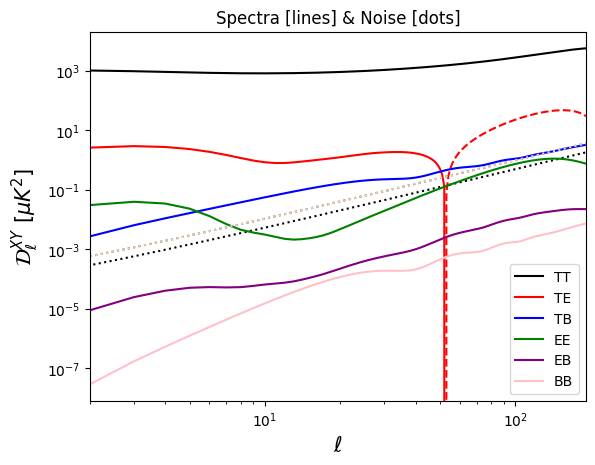

In [5]:
cols = ['k','r','b','g','purple','pink']
for i,f in enumerate(list(Cl_th.keys())):
    if np.sum(Cl_th[f]+Nl_th[f])==0: continue
    plt.plot(l,l*(l+1)/(2*np.pi)*Cl_th[f]*1e12,label=f,c=cols[i])
    plt.plot(l,-l*(l+1)/(2*np.pi)*Cl_th[f]*1e12,c=cols[i],ls='--')
    plt.plot(l,l*(l+1)/(2.*np.pi)*Nl_th[f]*1e12,c=cols[i],ls=':')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim([2,lmax])
plt.ylabel(r'$\mathcal{D}_\ell^{XY}$ [$\mu K^2$]',fontsize=15)
plt.xlabel(r'$\ell$',fontsize=15)
plt.title("Spectra [lines] & Noise [dots]");

### Load mask
For testing, we use a *Planck* 40\% sky mask with 2-degree apodization applied.

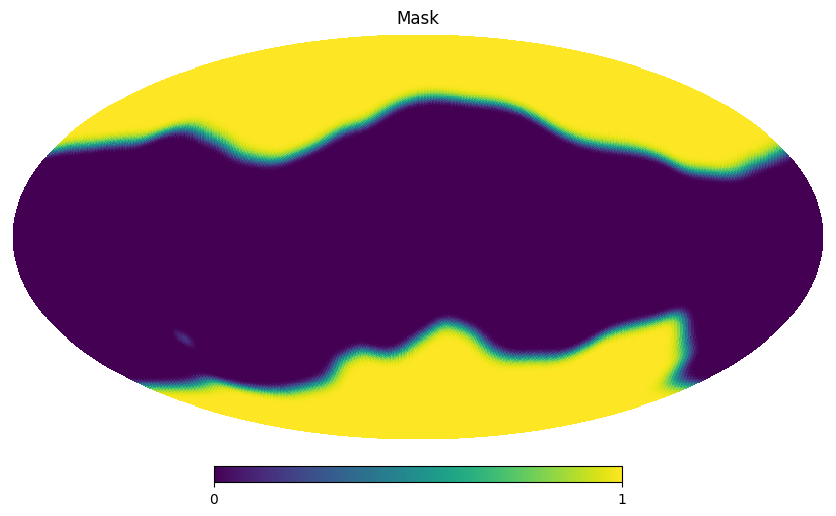

In [6]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Initialize PolyBin class

Let's start by calling the main PolyBin class. This contains a bunch of useful methods, including spherical harmonic transforms (via HEALPix or Libsharp, depending on our choice of backend) and code to generate random simulations. We can optionally add an experimental beam here too (note that the input data is *not* expected to be beam-deconvolved, but the output spectra will be). We can either run the code in polarization mode (`pol=True`) or scalar mode (`pol=False`). In the latter case, we only need to feed in $C_\ell^{TT}$ maps.

If we're analyzing high resolution data, we should turn on the pixel window function; here, we're generating data at the same $N_{\rm side}$ we analyze it at, so it's not needed.

In [7]:
# Define fiducial beam and signal+noise
if not pol:
    beam = [1.+0.*l]
else:
    beam = [1.+0.*l, 1.+0.*l] # Temperature and polarization
Sl_fiducial = {}
for f in Cl_th.keys(): Sl_fiducial[f] = beam[0]**2*Cl_th[f]+Nl_th[f]+(Cl_th[f][2]+Nl_th[f][2])*(l<2) # avoiding zeros at l<2

# Define class, optionally including polarization
base = pb.PolyBin(Nside, Sl_fiducial, beam, include_pixel_window=include_pixel_window, pol=pol, backend=backend)

## Caution: not accounting for pixel window function


Next, we'll create some synthetic data with a known $C_\ell^{XY}$. We can optionally add a bispectrum term: for simplicity, we use a factorized form with $b_{\ell_1\ell_2\ell_3}=\beta_{\ell_1}\beta_{\ell_2}\beta_{\ell_3}$ where $\beta$ was defined above. We will window this data with the *Planck* map.

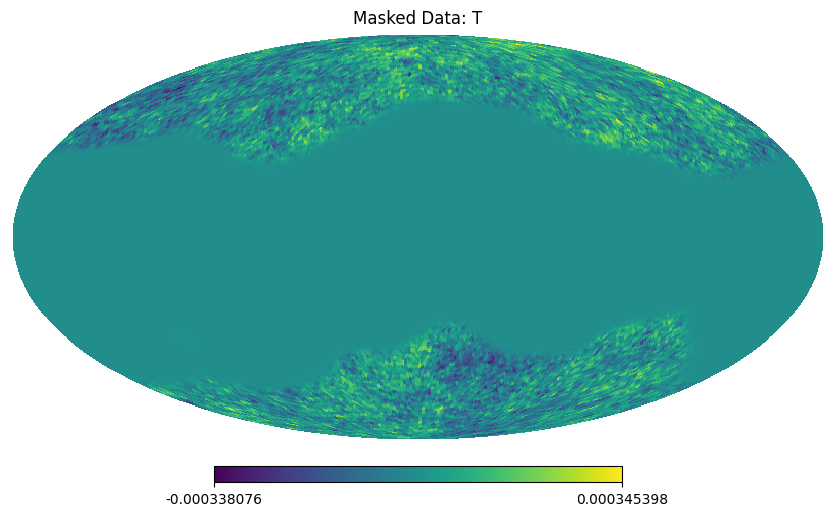

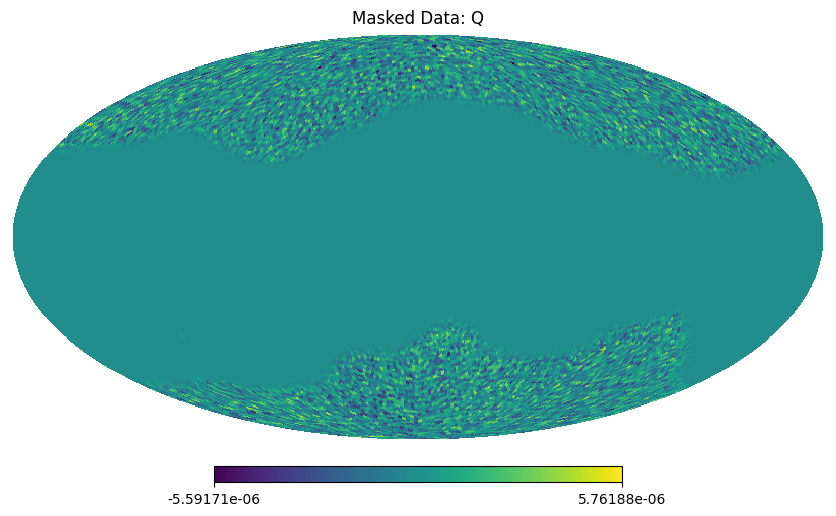

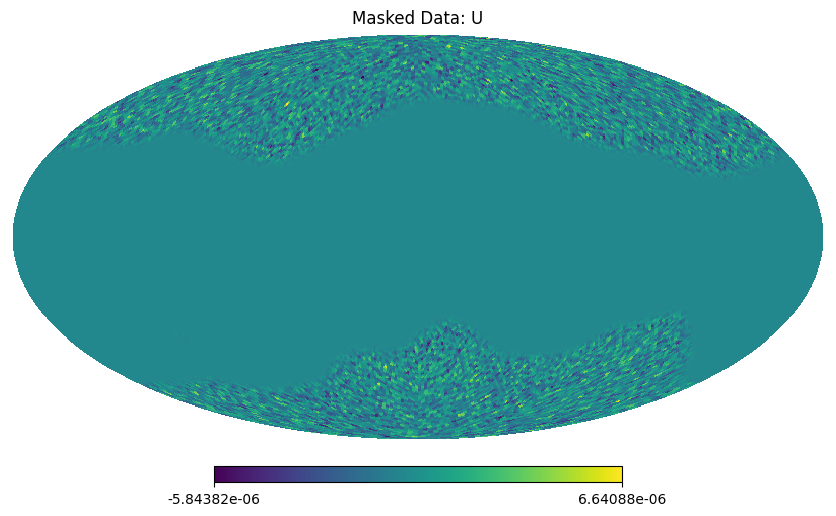

In [8]:
# Generate unmasked data with known C_l and factorized b
# Cl^XY are set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=False)

# Mask the map
data = (raw_data*mask).reshape(len(raw_data),-1)

# Plot the data
labels = ['T','Q','U']
for i in range(len(data)):
    healpy.mollview(data[i],title='Masked Data: %s'%labels[i])

### Define weighting function
A crucial input to the unwindowed estimators is a function, $\mathsf{S}^{-1}$, which provides quasi-optimal weighting to the data. A simple option would be ```applySinv=base.applyAinv```, which matches the code below. To form a fully optimal estimator, $\mathsf{S}^{-1}$ should be equal to the true inverse data covariance $\tilde{\mathsf{C}}^{-1}_{\rm fid}$ (which includes noise); in practice, it is usually sufficient to employ a diagonal weighting scheme. Note that the function can take either real- or harmonic-space maps as input and output; this avoids unnecessary forward and reverse transforms in the code.

In [9]:
def applySinv(input_map, input_type='map', output_type='map'):
    """Apply the quasi-optimal weighting, S^{-1} to a map in map- or harmonic-space. 
    
    Here, we assume that the forward covariance is diagonal in ell (though not in fields), in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but will be unbiased.
    
    Note that the code has two input and output options: "harmonic" or "map", to avoid unnecessary transforms.
    """
    assert input_type in ['harmonic','map'], "Valid input types are 'harmonic' and 'map' only!"
    assert output_type in ['harmonic','map'], "Valid output types are 'harmonic' and 'map' only!"
    
    # Transform to harmonic space, if necessary
    if input_type=='map': input_map_lm = base.to_lm(input_map)
    else: input_map_lm = input_map.copy()
    
    # Divide by covariance
    Cinv_data_lm = np.einsum('ijk,jk->ik',base.inv_Cl_lm_mat,input_map_lm,order='C')
        
    # Return to map-space, if necessary
    if output_type=='map': return base.to_map(Cinv_data_lm)
    else: return Cinv_data_lm

Let's plot the (approximately) Wiener filtered maps:

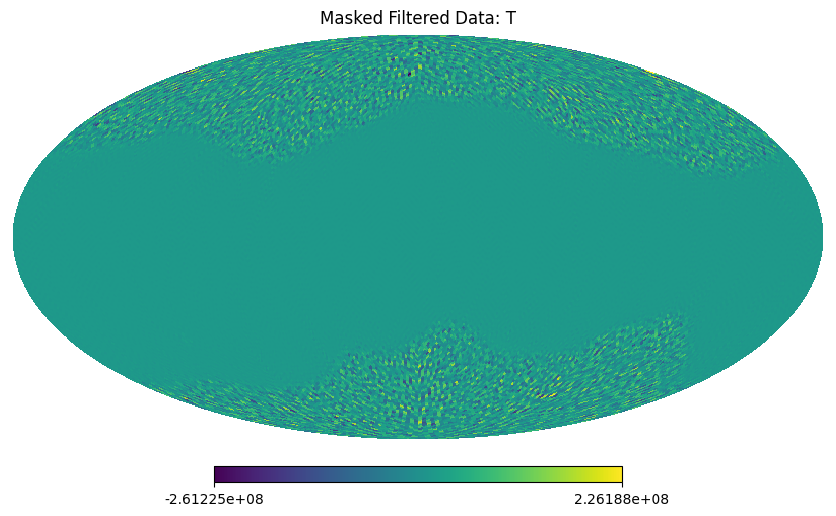

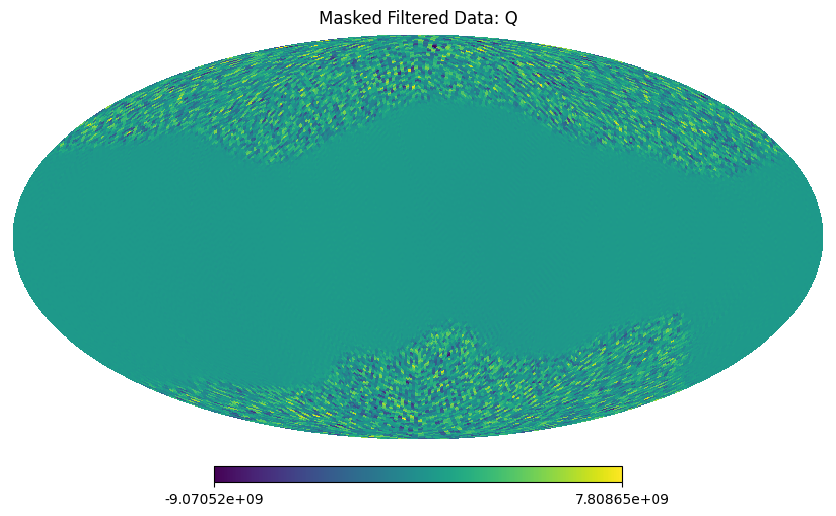

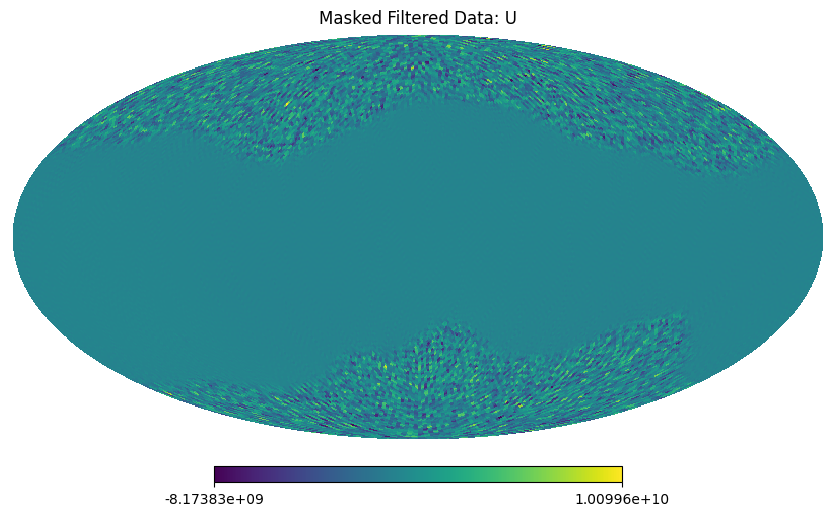

In [10]:
# Filter the map
Sinv_data = applySinv(data)

# Plot the data
labels = ['T','Q','U']
for i in range(len(Sinv_data)):
    healpy.mollview(Sinv_data[i],title='Masked Filtered Data: %s'%labels[i])

For complex masks, an alternative approach is to use a non-square weighting $\mathsf{S}^{-1}$ which projects out holes and poorly reproduced areas in the map. Below, we give an exemplar choice, matching that used in the Planck parity-odd trispectrum analysis. This employs both an inpainting mask and a smoothed non-invertible mask.

When using a $\mathsf{S}^{-1}$ filter like the below, one should *not* include the mask in the ```pspec```, ```bspec``` and ```tspec``` code below, since it has already been accounted for in the weighting.

In [11]:
########################### WEIGHTING ###########################

inpainting_mask = 0.*mask+np.random.randn(len(mask))>2.5 # for testing
smooth_mask = mask.copy() # combination of regular + inpainting mask

def inpaint_map(input_map):
    """
    Apply linear inpainting to a map, given an inpainting mask
    """
    
    tmp_map = input_map.copy()
    
    # Zero out inpainting regions 
    for i in range(len(tmp_map)):
        tmp_map[i][inpainting_mask==1] = 0 
    
    # Perform iterative impainting
    for i in range(1000):
        for f in range(len(tmp_map)):
            inpaint_pix = np.where((tmp_map[f]==0)&(inpainting_mask==1))[0]
            if len(inpaint_pix)==0:
                break
            # Identify four nearest neighbors
            neighbors = healpy.get_interp_weights(Nside,inpaint_pix)[0]
            tmp_map[f][inpaint_pix] = np.mean(tmp_map[f][neighbors],axis=0)

    return tmp_map

def applySinv_planck(input_map, input_type='map', output_type='map'):
    """
    Apply the quasi-optimal weighting, S^{-1} to a map. This firstly inpaints small holes in the data, applies a smooth mask, then weights by an ell-dependent factor.
    
    Note that this is neither diagonal nor invertible. The weighting is given by the inverse of Cl^{XY}_lm = B_l^2 C_l^XY + Kronecker[X,Y] N_l^XX here for beam B_l.
    
    The code has two input and output options: "harmonic" or "map", to avoid unnecessary transforms.
    """
    assert input_type in ['harmonic','map'], "Valid input types are 'harmonic' and 'map' only!"
    assert output_type in ['harmonic','map'], "Valid output types are 'harmonic' and 'map' only!"
    
    ## Transform to real-space, if necessary
    if input_type=='harmonic': 
        input_map = base.to_map(input_map)
        
    ## Step 1: inpaint the data
    tmp_map = inpaint_map(input_map)
    
    ## Step 2: mask out the large bad regions
    tmp_map *= smooth_mask
        
    ## Step 3: Apply S+N weighting in harmonic space
    Cinv_tmp_lm = np.einsum('ijk,jk->ik',base.inv_Cl_lm_mat,base.to_lm(tmp_map),order='C')
    
    # Return to map-space, if necessary
    if output_type=='map': return base.to_map(Cinv_tmp_lm)
    else: return Cinv_tmp_lm
    

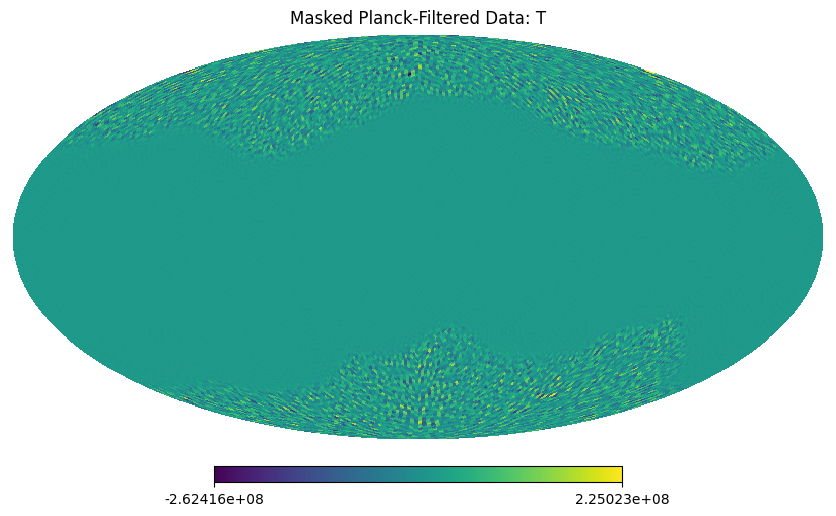

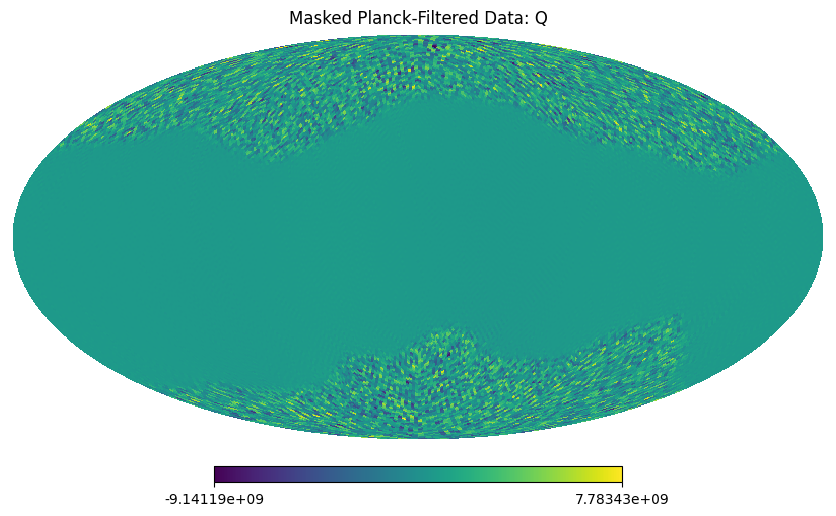

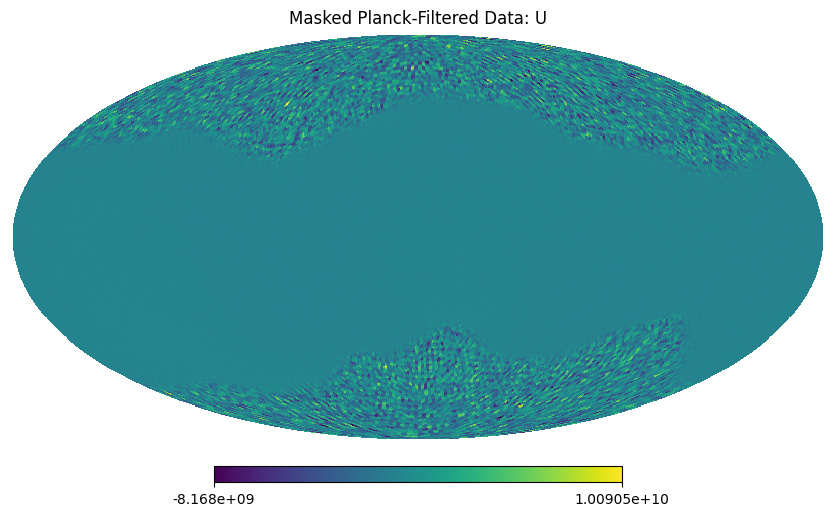

In [12]:
# Filter the map
Sinv_data_planck = applySinv_planck(data)

# Plot the data
labels = ['T','Q','U']
for i in range(len(Sinv_data_planck)):
    healpy.mollview(Sinv_data_planck[i],title='Masked Planck-Filtered Data: %s'%labels[i])

# 2. Power Spectrum Estimation

Let's compute the binned power spectrum of the map, using both the idealized and optimal estimators. The unwindowed estimator requires a Fisher matrix which we can compute via multiprocessing. Note that the Fisher matrix is independent of the data, thus only needs to be computed once per mask / binning choice.

We need to specify which spectra we want to compute: these can be any of $[TT,TE,TB,EE,EB,BB]$. Note that the code will compute and correct for the covariance between each spectrum listed (and *only* these).

In [3]:
# Initialize power spectrum class

# Define fields to use
if pol:
    fields=['TT','TE','TB','EE','EB','BB'] # can use any subset of these!
else:
    fields = ['TT']

# NB: use mask = 1.+0.*mask if including mask projection in S^-1 (as in applySinv_planck)
pspec = pb.PSpec(base, mask, applySinv, l_bins, fields=fields)

Binning: 4 bins in [5, 85]
Fields: ['TT', 'TE', 'TB', 'EE', 'EB', 'BB']
Mask: spatially varying


### Ideal Estimator

We'll begin by computing the (standard) idealized power spectrum estimator. This is straightforward to do, and involves only one harmonic transform (plus some $\ell$-space summations). The output is a dictionary, containing each power spectrum of interest.

In [4]:
# Compute idealized power spectrum
Cl_ideal = pspec.Cl_ideal(data)

# Compute the HEALPix unbinned pseudo-Cl power spectrum, for comparison
# Note that base.beam_lm includes the pixel window (if turned on)
data_lm = base.to_lm(data)
if pol:
    Cl_tmp = healpy.alm2cl([base.safe_divide(data_lm[i],base.beam_lm[i]) for i in range(3)])/np.mean(mask**2)
    Cl_raw_healpy = {}
    for field, healpy_index in zip(['TT','TE','TB','EE','EB','BB'],[0,3,5,1,4,2]):
        Cl_raw_healpy[field] = Cl_tmp[healpy_index] # reorder spectra
else:
    Cl_raw_healpy = {'TT':healpy.alm2cl(base.safe_divide(data_lm[0],base.beam_lm[i]))/np.mean(mask**2)}

Computing ideal Fisher matrix


In [5]:
# Define centers of l bins
ls = np.asarray(pspec.get_ells())

# Print out a few bin centers:
for i in range(min(len(ls),5)):
    print("Bin %d: l = %.1f"%(i,ls[i]))

Bin 0: l = 15.0
Bin 1: l = 35.0
Bin 2: l = 55.0
Bin 3: l = 75.0


### Unwindowed Estimator

For the unwindowed estimator, we'll first compute the Fisher matrix, then use this to compute the full unwindowed estimator. Since we need to compute the Fisher matrix for all combinations of bins and fields, this might take some time. Here we'll parallelize it on a single node.

In [6]:
# Zero counters (for diagnostics only)
base.n_SHTs_forward, base.n_SHTs_reverse = 0, 0

# Compute Fisher matrix, via multiprocessing
fish = pspec.compute_fisher(N_it, N_cpus=N_cpus, verb=True);

# Compute unwindowed power spectrum
Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

# Print some diagnostics
print("Computation complete using %d forward and %d reverse SHTs per iteration"%(base.n_SHTs_forward//N_it, base.n_SHTs_reverse//N_it))

Computing Fisher contribution 1 of 2
Generating GRF

Computing map for S^-1 weighting

Computing Q2 map for A^-1 weighting
Assembling Fisher matrix

Generating GRF

Computing map for S^-1 weighting

Computing Q2 map for A^-1 weighting
Assembling Fisher matrix

Computation complete using 58 forward and 151 reverse SHTs per iteration


Alternatively, we can assemble the Fisher matrix by hand (e.g., if we wish to distribute between many nodes). Then we just need to pass it to the estimator.

In [7]:
# # Iterate by hand
# fish = 0.
# for i in range(N_it):
#     if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
#     fish += pspec.compute_fisher_contribution(i, verb=(i==0))/N_it

# # Compute unwindowed power spectrum, passing the Fisher matrix
# Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

### Plots

Let's plot the results! We note that the final bin or two of the optimal estimator could be biased since we ignore the correlations with the higher bins. These would be excluded in any real analysis.

We also plot the Fisher matrix, which shows how correlated individual bins and fields are as a result of the window (and the intrinsic correlations between fields).

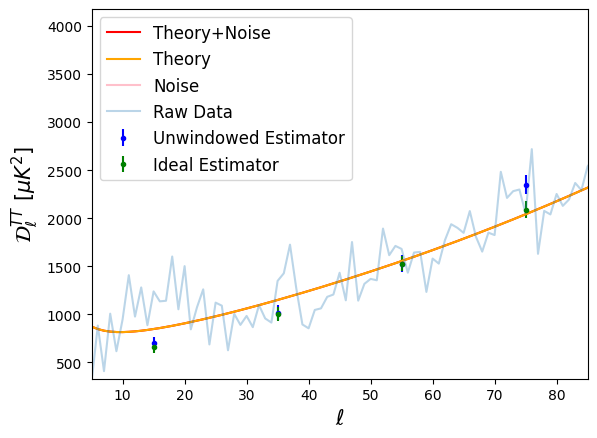

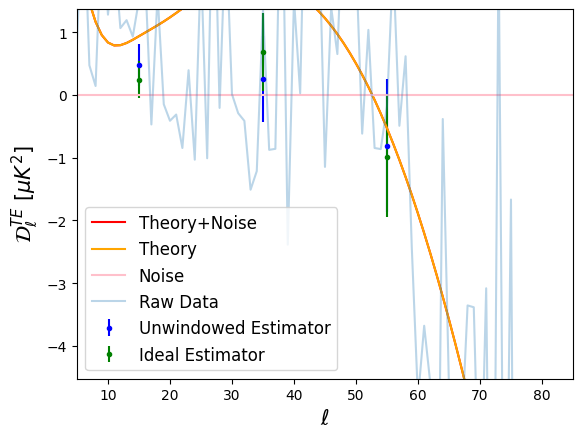

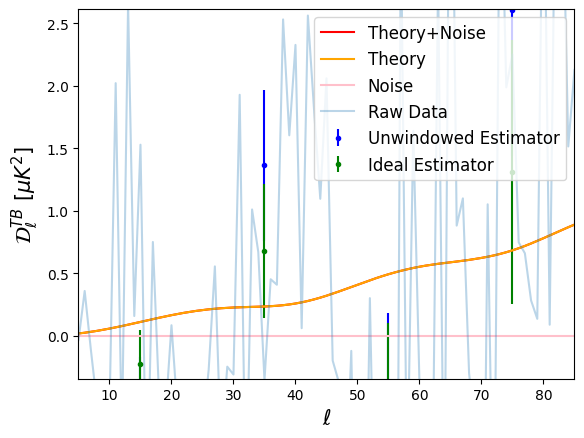

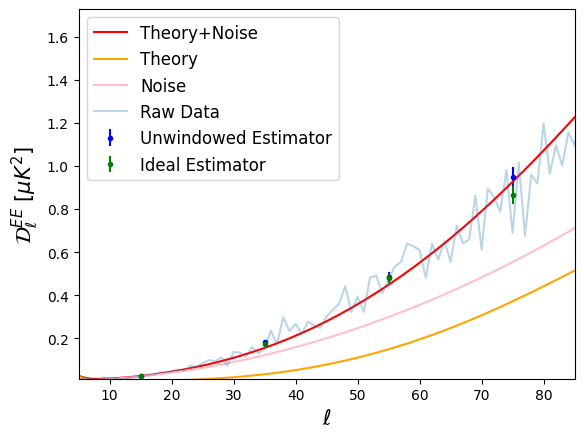

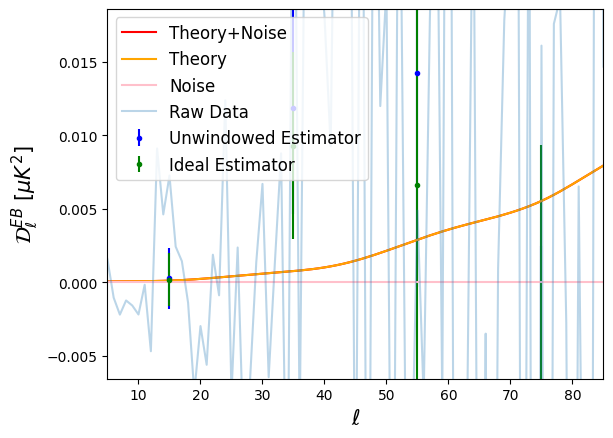

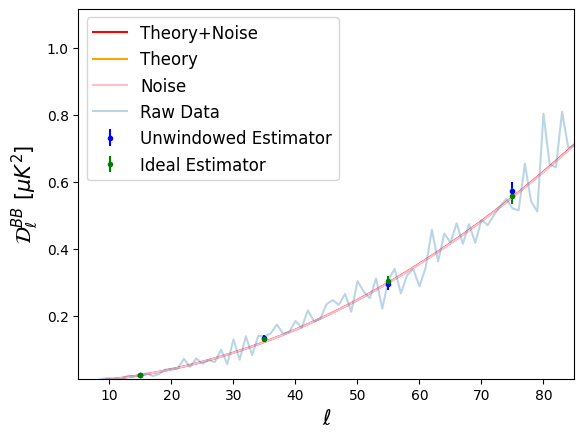

In [12]:
l_av = 0.5*(l_bins[1:]+l_bins[:-1])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12
pref = l*(l+1)/(2.*np.pi)*1e12

for i,field in enumerate(pspec.fields):
    
    # Fisher error
    fish_err = np.sqrt(np.diag(pspec.inv_fish)[i*pspec.Nl:(i+1)*pspec.Nl])
    fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal)[i*pspec.Nl:(i+1)*pspec.Nl])*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)
    
    # Plot spectra
    plt.figure()
    plt.errorbar(l_av,pref_av*Cl_opt[field],yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b')
    plt.errorbar(l_av,pref_av*Cl_ideal[field],yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal Estimator',c='g')
    plt.plot(l,pref*(Cl_th[field]+Nl_th[field]/(1e-12+beam[0]**2)),label='Theory+Noise',c='r')
    plt.plot(l,pref*Cl_th[field],label='Theory',c='orange')
    plt.plot(l,pref*(Nl_th[field]/(1e-12+beam[0]**2)),label='Noise',c='pink')
    plt.plot(l,pref*Cl_raw_healpy[field],label='Raw Data',alpha=0.3)
    plt.xlim([min(l_bins),max(l_bins)])
    plt.xlabel(r'$\ell$',fontsize=15)
    plt.ylabel(r'$\mathcal{D}^{%s}_\ell\,\,[\mu K^2]$'%pspec.fields[i],fontsize=15)
    plt.legend(fontsize=12)
    plt.ylim([0.5*min(pref_av*Cl_ideal[field]),2*max(pref_av*Cl_ideal[field])])

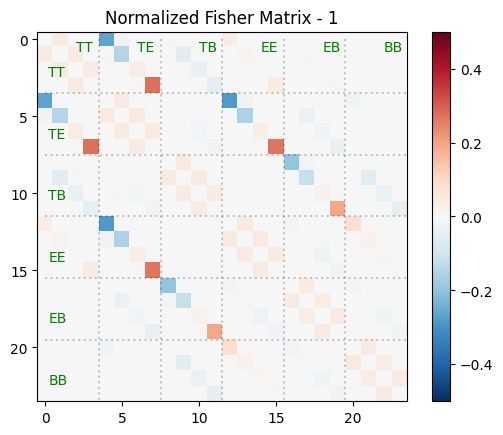

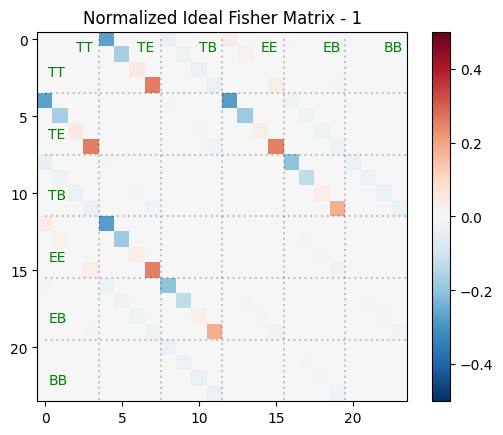

In [13]:
# Plot Fisher matrices (real and ideal)

def plot_correlation(matrix,v=0.5,title=''):
    # Define correlation
    corr_matrix = matrix/np.sqrt(np.outer(np.diag(matrix),np.diag(matrix)))

    # Plot matrix
    plt.figure()
    plt.imshow(corr_matrix-np.eye(len(corr_matrix)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    plt.title(title)
    plt.colorbar();
    
    for i in range(len(pspec.fields)):
        plt.hlines(i*pspec.Nl-0.5,0,len(pspec.fields)*pspec.Nl,linestyles=':',color='k',alpha=0.2)
        plt.vlines(i*pspec.Nl-0.5,0,len(pspec.fields)*pspec.Nl,linestyles=':',color='k',alpha=0.2)
    for i in range(len(pspec.fields)):
        plt.text((i+0.5)*pspec.Nl,pspec.Nl*0.2,pspec.fields[i],c='g')
        plt.text(pspec.Nl*0.05,(i+0.6)*pspec.Nl,pspec.fields[i],c='g')
    plt.xlim(-0.5,len(matrix)-0.5)
    plt.ylim(len(matrix)-0.5,-0.5)

plot_correlation(pspec.fish,title="Normalized Fisher Matrix - 1")
plot_correlation(pspec.fish_ideal,title="Normalized Ideal Fisher Matrix - 1")

### Validation
We can test whether the estimator is (close-to) minimum variance by iterating over GRF datasets. This is fast, since we don't need to recompute the Fisher matrix!

In [15]:
Cl_unwindowed_all, Cl_ideal_all, Cl_raw_all = [{f:[] for f in pspec.fields} for _ in range(3)]

for ii in range(N_sim):
    if ii%10==0: 
        print("Analyzing simulation %d of %d"%(ii+1,N_sim))
    
    # Generate data (pure GRFs here)
    raw_sim = base.generate_data(ii,add_B=False)
    sim = (raw_sim*mask).reshape(len(raw_data),-1)

    # Compute binned and unbinned power spectra
    this_unwindowed = pspec.Cl_unwindowed(sim)
    this_ideal = pspec.Cl_ideal(sim)
    
    # Add to dictionaries
    for f in pspec.fields:
        Cl_unwindowed_all[f].append(this_unwindowed[f])
        Cl_ideal_all[f].append(this_ideal[f])
    
    # Compute HEALPix power spectra
    raw_sim_lm = base.to_lm(raw_sim)
    if pol:
        Cl_tmp = healpy.alm2cl([base.safe_divide(raw_sim_lm[i],base.beam_lm[i]) for i in range(3)])
        for field, healpy_index in zip(['TT','TE','TB','EE','EB','BB'],[0,3,5,1,4,2]):
            Cl_raw_all[field].append(Cl_tmp[healpy_index]) # reorder spectra
    else:
        Cl_raw_all['TT'].append(healpy.alm2cl(base.safe_divide(raw_sim_lm[0],base.beam_lm[0])))

Analyzing simulation 1 of 50
Analyzing simulation 11 of 50
Analyzing simulation 21 of 50
Analyzing simulation 31 of 50
Analyzing simulation 41 of 50


Below, we plot the results. Importantly, the variance of the unwindowed estimator matches its Fisher matrix - i.e. it is roughly optimal! (Note that perfect optimality is only guaranteed if we use optimal weights).

However, it looks like the idealized estimator has a slightly *lower* variance? This is due to the off-diagonal correlations imposed by the window function, as seen in the correlation matrices.

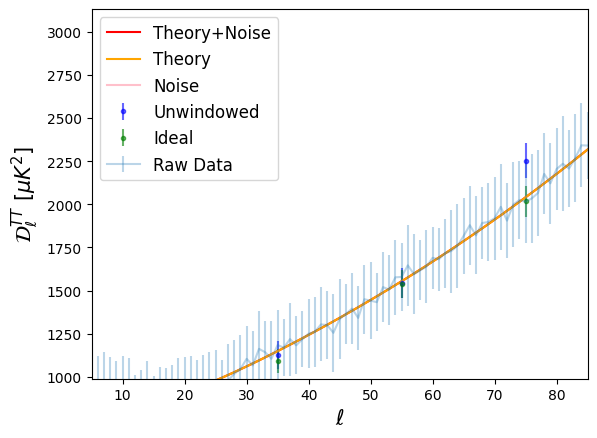

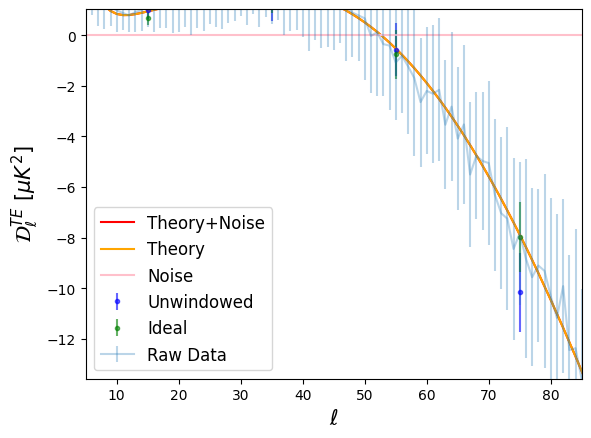

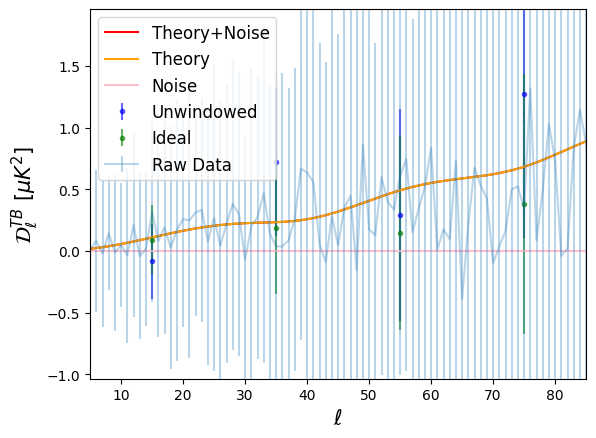

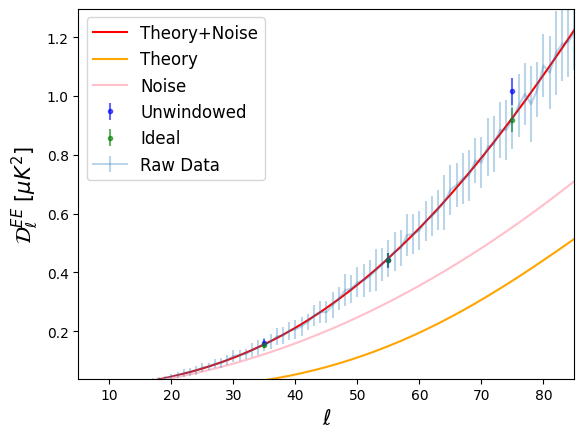

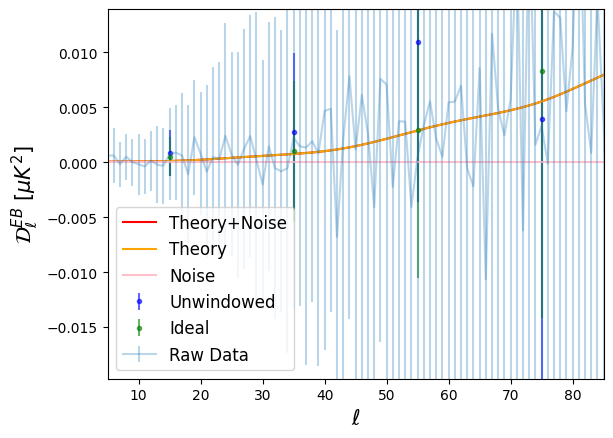

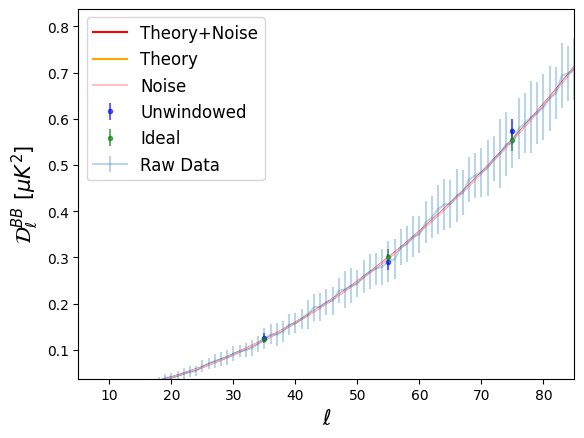

In [18]:
for i,field in enumerate(pspec.fields):
    
    # Fisher error
    fish_err = np.sqrt(np.diag(pspec.inv_fish)[i*pspec.Nl:(i+1)*pspec.Nl])
    fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal)[i*pspec.Nl:(i+1)*pspec.Nl])*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)
    
    # Plot spectra
    plt.figure()
    plt.errorbar(l_av,pref_av*np.asarray(Cl_unwindowed_all[field]).mean(axis=0),yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed',c='b',alpha=0.6)
    plt.errorbar(l_av,pref_av*np.asarray(Cl_ideal_all[field]).mean(axis=0),yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal',c='g',alpha=0.6)
    plt.plot(l,pref*(Cl_th[field]+Nl_th[field]/(1e-12+beam[0]**2)),label='Theory+Noise',c='r')
    plt.plot(l,pref*Cl_th[field],label='Theory',c='orange')
    plt.plot(l,pref*Nl_th[field]/(1e-12+beam[0]**2),label='Noise',c='pink')
    plt.errorbar(l,pref*np.mean(Cl_raw_all[field],axis=0),yerr=pref*np.std(Cl_raw_all[field],axis=0),label='Raw Data',alpha=0.3)
    plt.xlim([min(l_bins),max(l_bins)])
    plt.xlabel(r'$\ell$',fontsize=15)
    plt.ylabel(r'$\mathcal{D}^{%s}_\ell\,\,[\mu K^2]$'%field,fontsize=15)
    plt.legend(fontsize=12)
    plt.ylim([1.5*min(pref_av*Cl_ideal[field]),1.5*max(pref_av*Cl_ideal[field])])

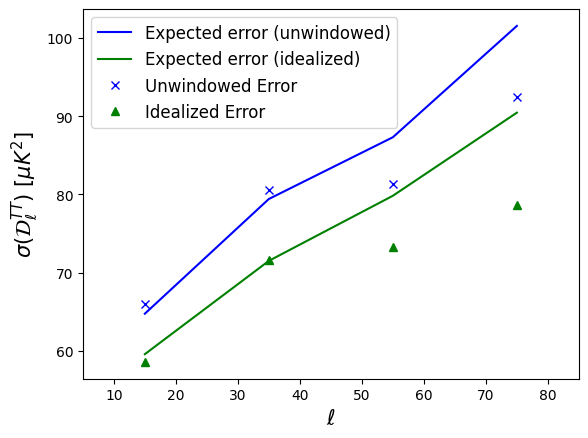

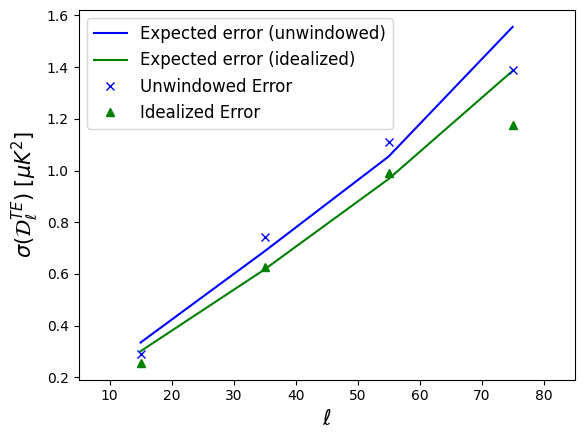

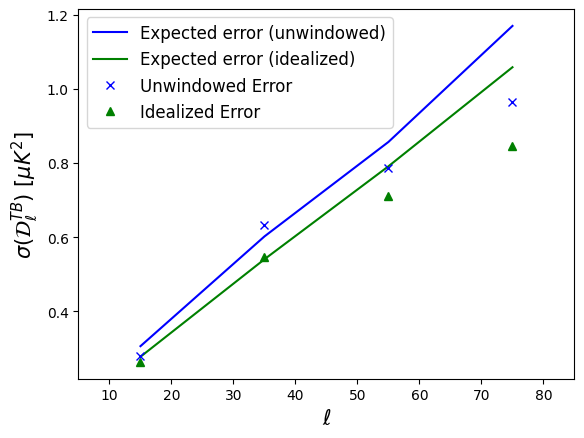

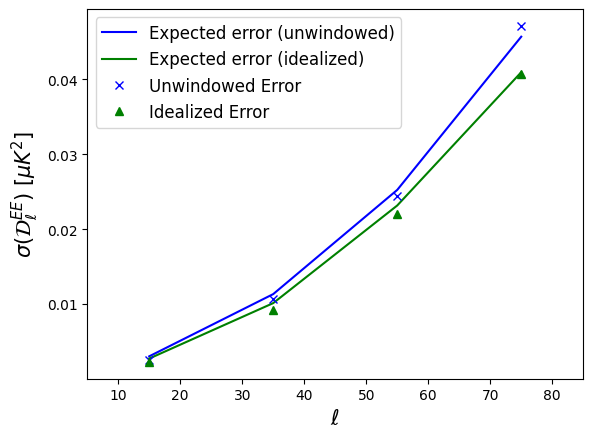

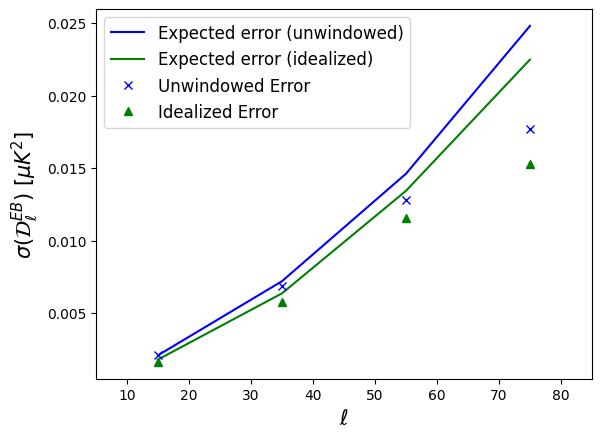

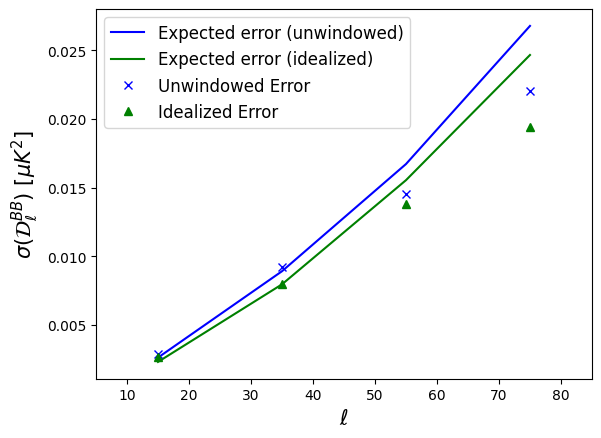

In [19]:
for i,field in enumerate(pspec.fields):
    
    # Fisher error
    fish_err = np.sqrt(np.diag(pspec.inv_fish)[i*pspec.Nl:(i+1)*pspec.Nl])
    fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal)[i*pspec.Nl:(i+1)*pspec.Nl])*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)
    
    # Plot spectra
    plt.figure()
    plt.plot(l_av,pref_av*fish_err,label='Expected error (unwindowed)',c='b')
    plt.plot(l_av,pref_av*fish_err_ideal,label='Expected error (idealized)',c='g')
    plt.plot(l_av,pref_av*np.std(Cl_unwindowed_all[field],axis=0),label='Unwindowed Error',c='b',marker='x',ls='')
    plt.plot(l_av,pref_av*np.std(Cl_ideal_all[field],axis=0),label='Idealized Error',c='g',marker='^',ls='')
    plt.xlim([min(l_bins),max(l_bins)])
    plt.xlabel(r'$\ell$',fontsize=15)
    plt.ylabel(r'$\sigma(\mathcal{D}^{%s}_\ell)\,\,[\mu K^2]$'%field,fontsize=15)
    plt.legend(fontsize=12)

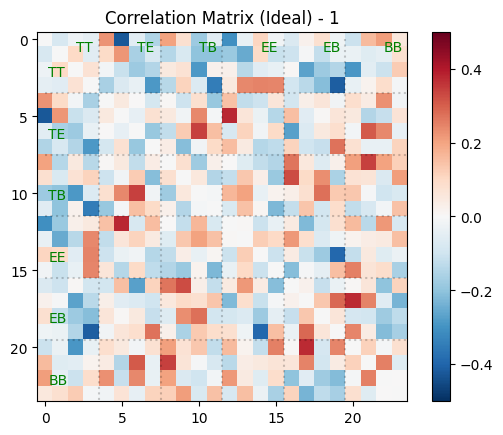

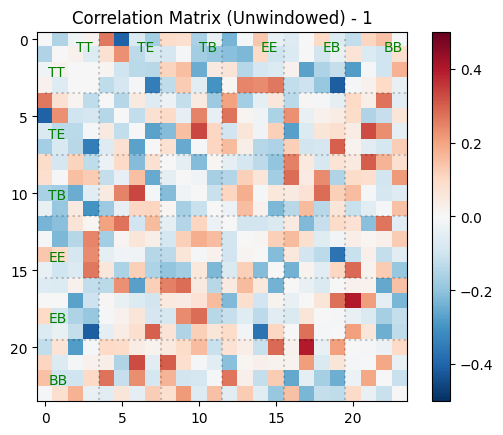

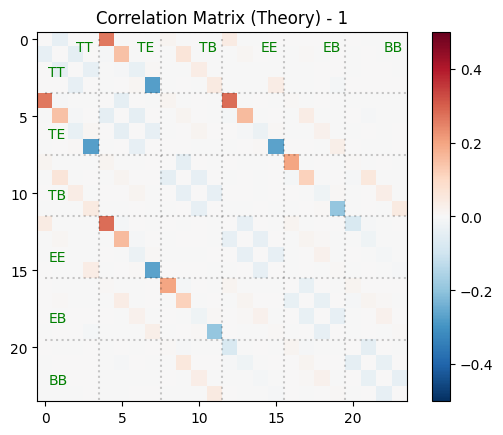

In [20]:
# Plot Fisher matrices (real and ideal)

cov_ideal = np.cov(np.hstack([Cl_ideal_all[f] for f in pspec.fields]).T)
cov_unwindowed = np.cov(np.hstack([Cl_unwindowed_all[f] for f in pspec.fields]).T)
cov_theory = np.linalg.inv(pspec.fish)
    
plot_correlation(cov_ideal,title="Correlation Matrix (Ideal) - 1")
plot_correlation(cov_unwindowed,title="Correlation Matrix (Unwindowed) - 1")
plot_correlation(cov_theory,title="Correlation Matrix (Theory) - 1")

# 3. Bispectrum Estimation

We now move to estimating the bispectrum, both via idealized and window-free estimators. As before, we will need to compute a Fisher matrix, depending on the survey geometry. To avoid the dimensionality (and run-time) getting out of hand, we will use a broad binning for this exercise, noting that bispectra are much more computationally expensive than power spectra! In practice, one would usually run the Fisher matrix on a cluster rather than on a laptop.

As for the power spectrum, we need to specify which spectra we want to compute: these can be any subset of $[TTT,TTE,TEE,EEE,TBB,EBB,TTB,TEB,EEB,BBB]$. Note that the code will compute and correct for the covariance between each spectrum listed (and *only* these). Here, we also need to specify which *parities* to compute, since the bispectrum is sensitive to parity-conserving and parity-breaking physics. Here, we'll consider both by default, though only parity-even is needed for scalar fields.

# CHANGING BINNING!

In [3]:
## Binning parameters
# Note that we can use separate binning for squeezed triangles
# l_bins = np.arange(5,45,10)
# l_bins_squeeze = np.arange(5,55,10)
l_bins = np.arange(2,55,10)
l_bins_squeeze = np.arange(2,55,10)

# Initialize bispectrum class
if pol:
    bspec = pb.BSpec(base, mask, applySinv, l_bins,l_bins_squeeze=l_bins_squeeze, 
                     fields=['TTT', 'TTE', 'TEE', 'EEE', 'TBB', 'EBB', 'TTB', 'TEB', 'EEB', 'BBB'], parity='both')
else:
    bspec = pb.BSpec(base, mask, applySinv, l_bins,l_bins_squeeze=l_bins_squeeze, 
                     fields=['TTT'], parity='even')

Binning: 5 bins in [2, 52]
Mask: spatially varying


In [4]:
# Compute centers of l1, l2, l3 bins for the temperature spectrum
# these can differ between spectra due to restrictions on bin1 <= bin2 etc.
l1s,l2s,l3s = np.asarray(bspec.get_ells('TTT'))

# Print out a few bin centers:
for i in range(min(len(l1s),5)):
    print("Bin %d: l1 = %.1f, l2 = %.1f, l3 = %.1f"%(i,l1s[i],l2s[i],l3s[i]))

Bin 0: l1 = 7.0, l2 = 7.0, l3 = 7.0
Bin 1: l1 = 7.0, l2 = 17.0, l3 = 17.0
Bin 2: l1 = 7.0, l2 = 27.0, l3 = 27.0
Bin 3: l1 = 7.0, l2 = 37.0, l3 = 37.0
Bin 4: l1 = 7.0, l2 = 47.0, l3 = 47.0


### Ideal Estimator

Let's start by computing the ideal bispectrum. This is a fair amount more expensive than before, requiring $\mathcal{O}(3N_{\rm bin})$ harmonic transforms. This function computes the normalization internally via an $\mathcal{O}(\ell_{\rm max}^3)$ sum over Wigner matrices involving $\ell_1,\ell_2,\ell_3$, which can be expensive for large $\ell_{\rm max}$. We'll also recompute the data, now including a $T$-mode primordial bispectrum (restricted to even $\ell_1+\ell_2+\ell_3$ here). 

The output is a dictionary containing each spectrum of interest, named '$XYZ\pm$' where $\chi=\pm$ indicates the parity. Note that we take the imaginary part of spectra with odd $\chi\,p_{XYZ}$ (e.g., $TTB+$, $TTT-$, etc.)

# REMOVING INJECTED BISPECTRUM!

In [5]:
N_it = 10

In [6]:
# Define separable reduced bispectrum 
# note this is for T, E, B if polarized - here we just use a T-mode spectrum
# we will also restrict l1+l2+l3 to be even below, though this is not required
if pol:
    # Compute E and B mode rescaling
    E_ratio = (Sl_fiducial['EE'][80]/Sl_fiducial['TT'][80])**(1./2.)
    B_ratio = (Sl_fiducial['BB'][80]/Sl_fiducial['TT'][80])**(1./2.)
    b_input_fac = lambda l1: np.asarray([1.,0.*E_ratio, 0.*B_ratio]).reshape(-1,1)*np.exp(-(l1-2)/40.)*2e-6
else:
    b_input_fac = lambda l1: [np.exp(-(l1-2)/40.)*2e-6]

# Compute data
print("## Generating data")
#data = mask*base.generate_data(seed=42, add_B=True, b_input=b_input_fac, sum_ells='even')
data = mask*base.generate_data(seed=42, add_B=False)

# Compute ideal bispectra
print("\n## Computing ideal bispectrum")
b_ideal = bspec.Bl_ideal(data, verb=True, N_cpus=40)

## Generating data

## Computing ideal bispectrum
Computing ideal Fisher matrix
Using 1 combination(s) of fields/parities
Using a maximum of 22 bins per field/parity
Using a total of 22 bins
Multiprocessing computation on 40 cores


100%|██████████| 22/22 [00:00<00:00, 33.28it/s]


Fisher matrix computation complete

Computing H maps
Analyzing bispectrum numerator for field TTT


### Window-free estimator
The window-free estimator can be computed similarly to the bispectrum, and involves a Fisher matrix that can be computed internally or externally. Since there are a large number of bin combinations and fields considered, the Fisher matrix might take a bit of time to compute.

We also require a set of simulations to form the linear term in the bispectrum estimator (i.e. that involving $d\langle{dd\rangle}$). These can be generated by the code (as GRFs, optionally with an added factorizable bispectrum), or read-in from some external source. These should have the same covariance as the data (but do not need to have accurate higher-order statistics). Here we'll generate the sims in harmonic space, to avoid unnecessary spherical harmonic transforms. 

Here, we load all simulations into memory , then compute the bispectra. If memory usage is a concern, one can set ```preload=False```, which loads one simulation at a time when needed. The simulation harmonic transforms are not saved in this mode, so must be recomputed for each new dataset analyzed.

In [7]:
# Generate MC simulations for estimator numerator
# No need for bispectrum contributions here!
bspec.generate_sims(N_it*5,add_B=False, preload=True, verb=True)

# # Alternatively, read-in MC simulations created externally
# def load_sim(ii):
#     """This function loads and returns a single simulation"""
#     return mask*base.generate_data(seed=int(1e5)+ii,add_B=False,output_type='map')
# bspec.load_sims(load_sim, N_it, verb=True, preload=False, input_type='map')

Using 50 Monte Carlo simulations
Generating bias simulation 1 of 50
Generating bias simulation 2 of 50
Generating bias simulation 3 of 50
Generating bias simulation 4 of 50
Generating bias simulation 5 of 50
Generating bias simulation 6 of 50
Generating bias simulation 7 of 50
Generating bias simulation 8 of 50
Generating bias simulation 9 of 50
Generating bias simulation 10 of 50
Generating bias simulation 11 of 50
Generating bias simulation 12 of 50
Generating bias simulation 13 of 50
Generating bias simulation 14 of 50
Generating bias simulation 15 of 50
Generating bias simulation 16 of 50
Generating bias simulation 17 of 50
Generating bias simulation 18 of 50
Generating bias simulation 19 of 50
Generating bias simulation 20 of 50
Generating bias simulation 21 of 50
Generating bias simulation 22 of 50
Generating bias simulation 23 of 50
Generating bias simulation 24 of 50
Generating bias simulation 25 of 50
Generating bias simulation 26 of 50
Generating bias simulation 27 of 50
Gene

In [8]:
# Zero counters (for diagnostics only)
base.n_SHTs_forward, base.n_SHTs_reverse = 0, 0

# Compute the Fisher matrix, via multiprocessing
fish = bspec.compute_fisher(N_it, N_cpus=N_cpus)

# Compute the unwindowed estimator, optionally removing the linear term
b_unwindowed = bspec.Bl_unwindowed(data, verb=True, include_linear_term=True)

# Print some diagnostics
print("Computation complete using %d forward and %d reverse SHTs per iteration"%(base.n_SHTs_forward//N_it, base.n_SHTs_reverse//N_it))

Computing Fisher contribution 1 of 10
Computing Fisher contribution 6 of 10
Computing H maps
Computing b_3 piece
Computing b_1 piece from simulation 5
Computing b_1 piece from simulation 10
Computing b_1 piece from simulation 15
Computing b_1 piece from simulation 20
Computing b_1 piece from simulation 25
Computing b_1 piece from simulation 30
Computing b_1 piece from simulation 35
Computing b_1 piece from simulation 40
Computing b_1 piece from simulation 45
Computing b_1 piece from simulation 50
Computation complete using 212 forward and 179 reverse SHTs per iteration


As before, we can compute the Fisher matrix externally (e.g., on a cluster) and read it in.

In [9]:
# # Iterate by hand
# fish = 0.
# for i in range(N_it):
#     if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
#     fish += bspec.compute_fisher_contribution(i, verb=(i==0))/N_it

# # Compute unwindowed estimator, passing the Fisher matrix
# b_unwindowed = bspec.Bl_unwindowed(data, verb=True, fish=fish, include_linear_term=True)

### Plots

Now let's plot the results!

Bispectra are harder to plot than power spectra, due to their higher dimensionality. Here, we'll just stack all the data into one dimension for each choice of fields and parity index, reading off the spectra from the output dictionaries produced by PolyBin. This starts with $b_1=b_2=b_3=1$, then updates each bin in turn, starting with $b_3$ and selecting only bins satisfying the triangle condition.

Below, we'll compare the results from the two estimators as well as the theory model for each component:

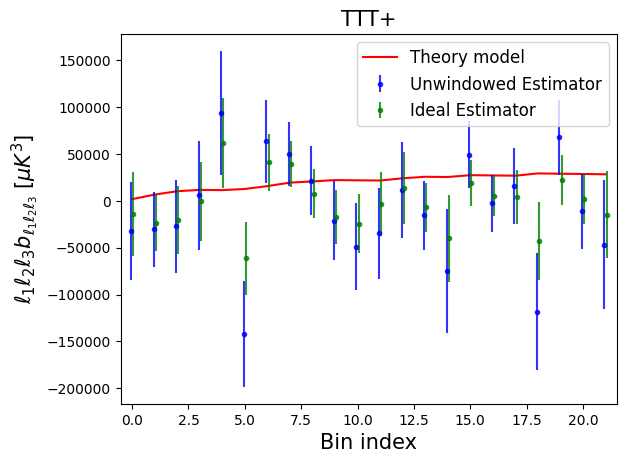

In [10]:
index = 0
for i,f in enumerate(b_ideal.keys()):
    
    ells_sum = np.product([base.parities[ff] for ff in f[:-1]])*int('%s'%f[-1]+'1')
    
    # Define weights and model
    l1s,l2s,l3s = np.asarray(bspec.get_ells(field=f[:-1]))
    weights = l1s*l2s*l3s*1e18
    bl_model = np.product([b_input_fac([l1s,l2s,l3s][i])[base.indices[f[i]]] for i in range(3)],axis=0)
    
    # Fisher Error
    fish_err = np.sqrt(np.diag(bspec.inv_fish)[index:index+len(bspec.sym_factor_all[i])])
    fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal)[index:index+len(bspec.sym_factor_all[i])])*np.sqrt(np.mean(mask**6.)/np.mean(mask**3)**2)
    index += len(bspec.sym_factor_all[i])

    plt.figure()
    x_arr = np.arange(len(fish_err_ideal))
    if ells_sum==1:
        plt.plot(x_arr,weights*bl_model,label='Theory model',c='r')
    else:
        plt.plot(x_arr,0*weights*bl_model,label='Theory model',c='r')
    plt.errorbar(x_arr-0.05,weights*b_unwindowed[f],yerr=weights*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
    plt.errorbar(x_arr+0.05,weights*b_ideal[f],yerr=weights*fish_err_ideal,ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
    plt.xlim([-0.5,len(x_arr)-0.5])
    plt.xlabel(r'Bin index',fontsize=15)
    plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
    plt.legend(fontsize=12)
    plt.title('%s'%f, fontsize=15)

We'll also consider the Fisher matrix (both true and ideal). Notably, we can see non-trivial off-diagonal correlations imparted by the survey geometry and by correlations between different fields. The spectra is usually close to block-diagonal: in the ideal limit, there are no correlations between bispectra with different numbers of $B$ modes (since $C_\ell^{EB}=C_\ell^{TB}=0$ usually), and none between parity-even and parity-odd physics.

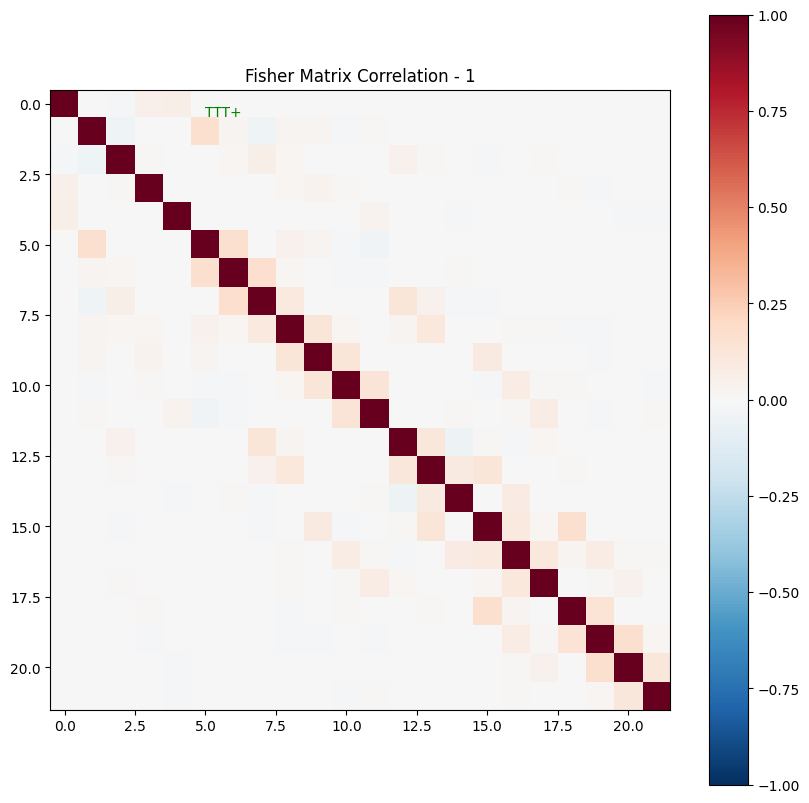

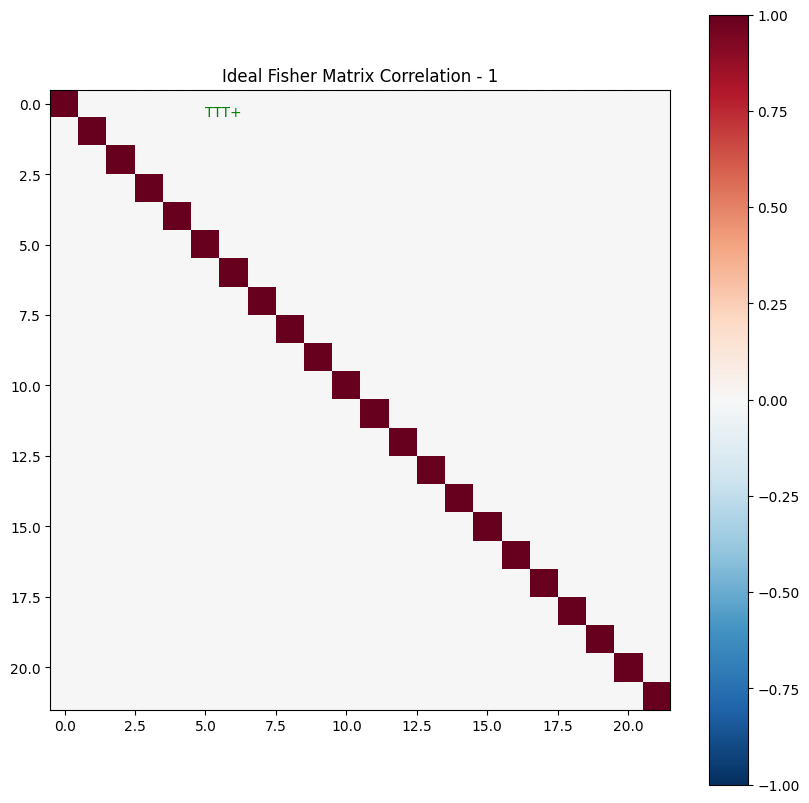

In [11]:
def plot_bis_correlation(matrix,v=0.5,title='',remove_diagonal=True):
    # Define correlation
    corr_matrix = matrix/np.sqrt(np.outer(np.diag(matrix),np.diag(matrix)))

    # Plot matrix
    plt.figure(figsize=(10,10))
    plt.imshow(corr_matrix-remove_diagonal*np.eye(len(corr_matrix)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    plt.title(title)
    plt.colorbar();
    
    i1 = 0
    for i in range(len(b_ideal.keys())):
        plt.hlines(i1-0.5,-0.5,len(matrix),linestyles=':',color='k',alpha=0.2)
        plt.vlines(i1-0.5,-0.5,len(matrix),linestyles=':',color='k',alpha=0.2)
        i1 += len(bspec.sym_factor_all[i])
    i1 = 0.
    for i in range(len(b_ideal.keys())):
        plt.text(i1+len(bspec.sym_factor_all[i])//4,len(matrix)*0.02,list(b_ideal.keys())[i],c='g')
        i1 += len(bspec.sym_factor_all[i])
    i1 = 0.
    for i in range(len(b_ideal.keys())):
        if i>0: plt.text(len(matrix)*0.005,i1+len(bspec.sym_factor_all[i])//2,list(b_ideal.keys())[i],c='g')
        i1 += len(bspec.sym_factor_all[i])
    plt.xlim(-0.5,len(matrix)-0.5)
    plt.ylim(len(matrix)-0.5,-0.5)

plot_bis_correlation(bspec.fish, v=1, title='Fisher Matrix Correlation - 1', remove_diagonal=False)
plot_bis_correlation(bspec.fish_ideal, v=1, title='Ideal Fisher Matrix Correlation - 1', remove_diagonal=False)

### Validation

To test the estimators, we can compute the variance from a suite of mock datasets, as for the power spectrum. This is comparatively cheap, since we have already loaded the Monte Carlo simulations (for the linear term) and the Fisher matrix.

# REMOVING INJECTED BISPECTRUM!

In [ ]:
# Set counters to zero
base.n_SHTs_forward, base.n_SHTs_reverse = 0, 0

# Define arrays
b_unwindowed_all = {f:[] for f in b_ideal.keys()}
b3_unwindowed_all = {f:[] for f in b_ideal.keys()}
b_ideal_all = {f:[] for f in b_ideal.keys()}

for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    data = mask*base.generate_data(jj,add_B=False)#True, b_input=b_input_fac, remove_mean=True, sum_ells='even')
    
    # Analyze sim
    this_Bl_ideal = bspec.Bl_ideal(data, verb=False)
    this_Bl_unwindowed = bspec.Bl_unwindowed(data, verb=False)
    this_Bl3_unwindowed = bspec.Bl_unwindowed(data, verb=False, include_linear_term=False)
    
    # Add to arrays
    for f in b_ideal.keys():
        b_ideal_all[f].append(this_Bl_ideal[f])
        b_unwindowed_all[f].append(this_Bl_unwindowed[f])
        b3_unwindowed_all[f].append(this_Bl3_unwindowed[f])
    
# Print some diagnostics
print("Computation complete using %d forward and %d reverse SHTs per simulation"%(base.n_SHTs_forward//N_sim, base.n_SHTs_reverse//N_sim))

Analyzing simulation 1 of 50
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
Analyzing simulation 11 of 50
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
No linear correction applied!
Analyzing simulation 21 of 50
No linear correction applied!


Below, we plot the results and, below, their errorbars. Once again, the variance is very close to the Fisher matrix prediction, i.e. we are close to optimal! We note that there is some inflation in the recovered errors due to the injected bispectrum. Furthermore, if too few simulations are used in the 1-field term, this will lead to an increase in the unwindowed estimator variance. Finally, we note that some bins with $p_u\,\chi=-1$ show large variances: this occurs if all the bins are equal, whence $\ell_1+\ell_2+\ell_3$ is forced to be even.

In [ ]:
plt.plot(np.std(b_unwindowed_all['TTT+'],axis=0)/np.std(b3_unwindowed_all['TTT+'],axis=0))

### this doesn't look correct!

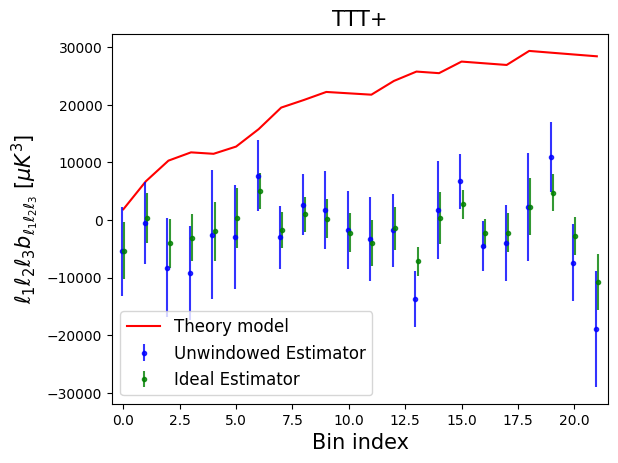

In [117]:
index = 0
for i,f in enumerate(b_ideal.keys()):
    
    ells_sum = np.product([base.parities[ff] for ff in f[:-1]])*int('%s'%f[-1]+'1')
    
    # Define weights and model
    l1s,l2s,l3s = np.asarray(bspec.get_ells(field=f[:-1]))
    weights = l1s*l2s*l3s*1e18
    bl_model = np.product([b_input_fac([l1s,l2s,l3s][i])[base.indices[f[i]]] for i in range(3)],axis=0)
    
    plt.figure()
    x_arr = np.arange(len(bl_model))
    if ells_sum==1:
        plt.plot(x_arr,weights*bl_model,label='Theory model',c='r')
    else:
        plt.plot(x_arr,0*weights*bl_model,label='Theory model',c='r')
    plt.errorbar(x_arr-0.05,weights*np.mean(b_unwindowed_all[f],axis=0),yerr=weights*np.std(b_unwindowed_all[f],axis=0)/np.sqrt(N_sim),marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
    plt.errorbar(x_arr+0.05,weights*np.mean(b_ideal_all[f],axis=0),yerr=weights*np.std(b_ideal_all[f],axis=0)/np.sqrt(N_sim),ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
    plt.xlim([-0.5,len(x_arr)-0.5])
    plt.xlabel(r'Bin index',fontsize=15)
    plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
    plt.legend(fontsize=12)
    plt.title('%s'%f, fontsize=15)

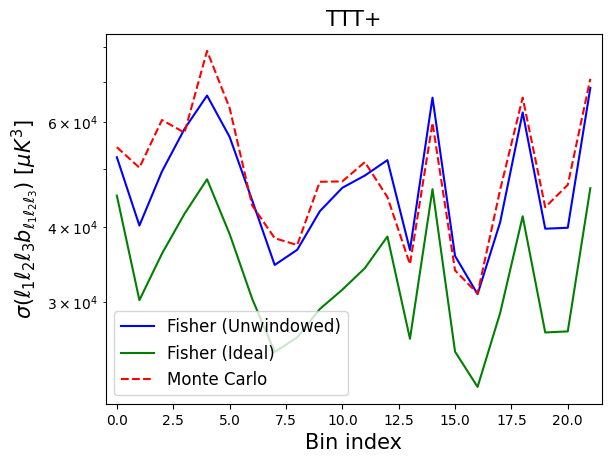

In [118]:
index = 0
for i,f in enumerate(b_ideal.keys()):
    
    ells_sum = np.product([base.parities[ff] for ff in f[:-1]])*int('%s'%f[-1]+'1')
    
    # Define weights
    l1s,l2s,l3s = np.asarray(bspec.get_ells(field=f[:-1]))
    weights = l1s*l2s*l3s*1e18
    
    # Fisher Error
    fish_err = np.sqrt(np.diag(bspec.inv_fish)[index:index+len(bspec.sym_factor_all[i])])
    fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal)[index:index+len(bspec.sym_factor_all[i])])*np.sqrt(np.mean(mask**6.)/np.mean(mask**3)**2)
    index += len(bspec.sym_factor_all[i])
    
    plt.figure()
    x_arr = np.arange(len(fish_err))
    plt.plot(x_arr,weights*fish_err,label='Fisher (Unwindowed)',c='b')
    plt.plot(x_arr,weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
    plt.plot(x_arr,weights*np.asarray(b_unwindowed_all[f]).std(axis=0),label='Monte Carlo',c='r',ls='--')
    plt.xlabel(r'Bin index',fontsize=15)
    plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);
    plt.xlim([-0.5,len(x_arr)-0.5])
    plt.legend(fontsize=12)
    plt.title('%s'%f, fontsize=15)
    plt.yscale('log')

Finally we compare the correlation structure of the estimator to the inverted Fisher matrix; this is noisy, but shows good overall agreement.

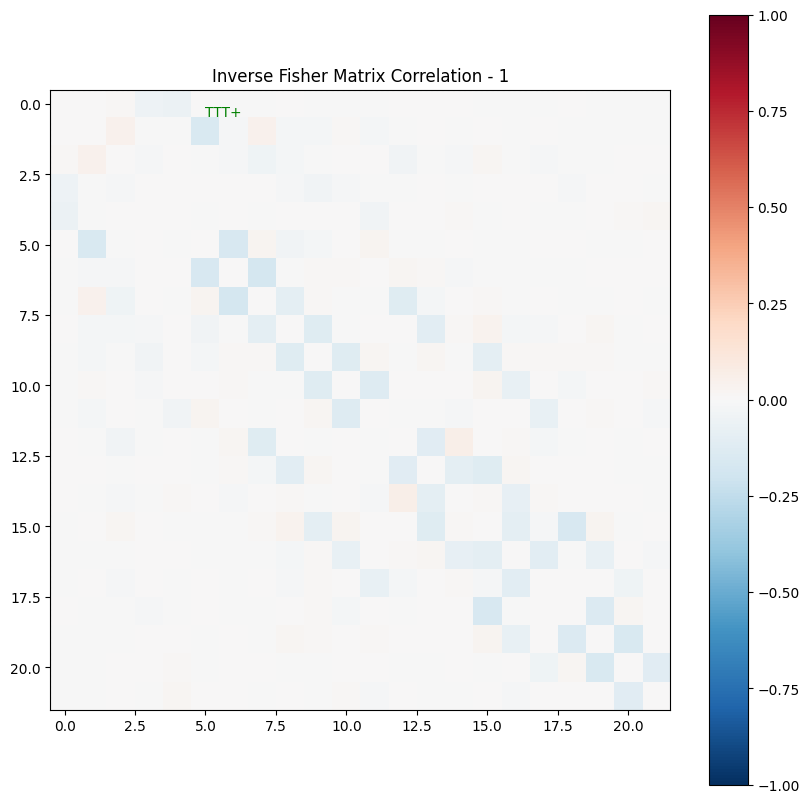

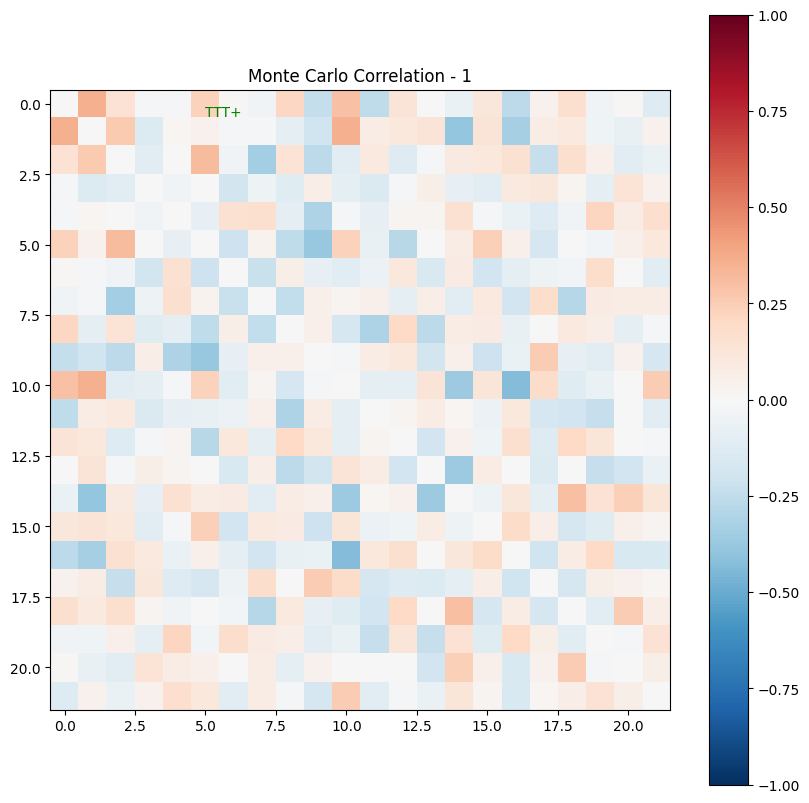

In [119]:
cov_ideal = np.cov(np.hstack([b_unwindowed_all[f] for f in b_ideal.keys()]).T)
plot_bis_correlation(np.linalg.inv(bspec.fish), title='Inverse Fisher Matrix Correlation - 1', v=1.)
plot_bis_correlation(cov_ideal, title='Monte Carlo Correlation - 1', v=1.)

# 4. Trispectrum Estimation

Finally, we consider the trispectrum. This is computed in a similar way to before, again involving both parity-even and parity-odd contributions. In this case, parity-odd physics can lead to a non-trivial temperature four-point function in the presence of rotational symmetries (unlike for the bispectrum).

Since trispectrum estimation is considerably more expensive than power spectrum or bispectrum estimation, we'll use a broader binning here and low $\ell_{\rm max}$. In general, calculations would be performed on a cluster, but we'll pick a small problem below for testing on a single computer.

In [23]:
# Initialize trispectrum class and pick binning
l_bins_raw = np.arange(12,20,3)
# We could also use a non-linear binning: the scaling of the option below gives roughly equal (S/N)^2 per bin
# l_bins_raw = np.asarray(5+np.arange(0,70**0.4,2**0.4)**2.5,dtype='int')

# Let's also use slightly lower l_max for collapsed and unsqueezed configurations
l_bins_squeeze = l_bins_raw.copy()
L_bins = l_bins_raw.copy()#[:-1]
l_bins = l_bins_raw.copy()#[:-1]

In [24]:
# Define class
if pol:
    tspec = pb.TSpec(base, mask, applySinv, l_bins, l_bins_squeeze=l_bins_squeeze, L_bins=L_bins, 
                    fields=['TTTT','TTTE','TBTB','TTEB','EBEB','EEEB'], parity='both')
else:
    tspec = pb.TSpec(base, mask, applySinv, l_bins, l_bins_squeeze=l_bins_squeeze, L_bins=L_bins, 
                     fields=['TTTT'], parity='both')    

Binning: 2 bins in [12, 18]
Mask: ones


In [120]:
# Define centers of l1, l2, l3, l4, L bins
l1s,l2s,l3s,l4s,Ls = tspec.get_ells('TTTT')
print("Using %d bins in total"%len(l1s))

# Print out a few bin centers:
for i in range(min(len(l1s),5)):
    print("Bin %d: l1 = %d, l2 = %d,l3 = %d, l4=%d, L=%d"%(i,l1s[i],l2s[i],l3s[i],l4s[i],Ls[i]))

Using 12 bins in total
Bin 0: l1 = 13, l2 = 13,l3 = 13, l4=13, L=13
Bin 1: l1 = 13, l2 = 13,l3 = 13, l4=13, L=16
Bin 2: l1 = 13, l2 = 13,l3 = 13, l4=16, L=13
Bin 3: l1 = 13, l2 = 13,l3 = 13, l4=16, L=16
Bin 4: l1 = 13, l2 = 13,l3 = 16, l4=16, L=13


### Ideal Estimator

As before, we start by computing the ideal trispectrum. The numerator has similar computational scaling to the bispectrum, but involves a few more spherical harmonic transforms, to account for the $L$ diagonal vector. The ideal estimator computes the normalization internally via a sum over a selection of Wigner $3j$ and $6j$ matrices: notably this is not diagonal, unlike for the power spectrum and bispectrum. Computation may take a while if $\ell_{\rm max}$ is large!

As before, the estimator spits out a dictionary with trispectra for all combinations of fields specified on initialization, and (optionally) both even- and odd-parity physics.

Before computing the ideal spectra, the code will compute the ideal Fisher matrix. This may be computationally expensive for large $\ell_{\rm max}$, and can be optionally multiprocessed.

In [28]:
# Generate data
data = mask*base.generate_data(seed=42, add_B=False)

t_ideal = tspec.Tl_ideal(data, verb=True, N_cpus=N_cpus)



Computing ideal Fisher matrix
Computing Fisher matrix row 1 of 124
Computing Fisher matrix row 11 of 124
Computing Fisher matrix row 21 of 124
Computing Fisher matrix row 31 of 124
Computing Fisher matrix row 41 of 124
Computing Fisher matrix row 51 of 124
Computing Fisher matrix row 61 of 124
Computing Fisher matrix row 71 of 124
Computing Fisher matrix row 81 of 124
Computing Fisher matrix row 91 of 124
Computing Fisher matrix row 101 of 124
Computing Fisher matrix row 111 of 124
Computing Fisher matrix row 121 of 124
Fisher matrix computation complete


Computing H maps
Computing A_lm fields
Computing empirical power spectra
Assembling 2- and 0-field trispectrum numerator


100%|██████████| 124/124 [00:00<00:00, 348.50it/s]



Assembling trispectrum numerator
Analyzing trispectrum numerator for field TTTT
Analyzing trispectrum numerator for field TTTE
Analyzing trispectrum numerator for field TBTB
Analyzing trispectrum numerator for field TTEB
Analyzing trispectrum numerator for field EBEB
Analyzing trispectrum numerator for field EEEB


Let's look at the structure of the Fisher matrices:

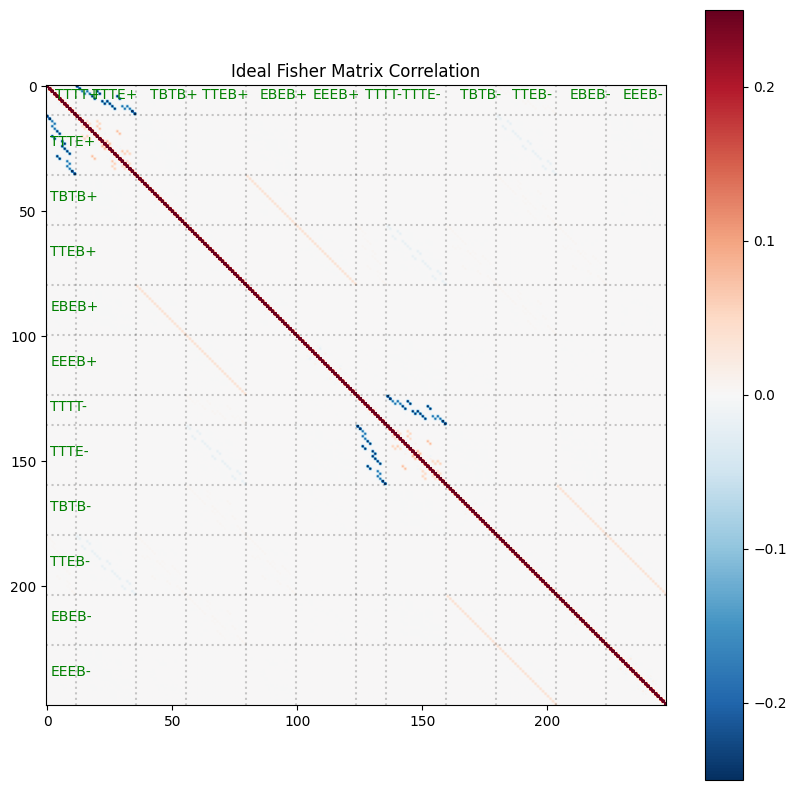

In [29]:
def plot_tri_correlation(matrix,v=0.5,title='',remove_diagonal=True, size_rescaling=1):
    # Define correlation
    corr_matrix = matrix/np.sqrt(np.outer(np.diag(matrix),np.diag(matrix)))

    # Plot matrix
    plt.figure(figsize=(10*size_rescaling,10*size_rescaling))
    plt.imshow(corr_matrix-remove_diagonal*np.eye(len(corr_matrix)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    plt.title(title)
    plt.colorbar();
    
    i1 = 0
    for i in range(len(t_ideal.keys())):
        plt.hlines(i1-0.5,-0.5,len(matrix),linestyles=':',color='k',alpha=0.2)
        plt.vlines(i1-0.5,-0.5,len(matrix),linestyles=':',color='k',alpha=0.2)
        i1 += len(tspec.sym_factor_all[i])
    i1 = 0.
    for i in range(len(t_ideal.keys())):
        plt.text(i1+len(tspec.sym_factor_all[i])//4,len(matrix)*0.02,list(t_ideal.keys())[i],c='g')
        i1 += len(tspec.sym_factor_all[i])
    i1 = 0.
    for i in range(len(t_ideal.keys())):
        if i>0: plt.text(len(matrix)*0.005,i1+len(tspec.sym_factor_all[i])//2,list(t_ideal.keys())[i],c='g')
        i1 += len(tspec.sym_factor_all[i])
    plt.xlim(-0.5,len(matrix)-0.5)
    plt.ylim(len(matrix)-0.5,-0.5)

plot_tri_correlation(tspec.fish_ideal, v=0.25, title='Ideal Fisher Matrix Correlation', remove_diagonal=False)

As expected, these are not quite diagonal, even for auto-trispectra! This occurs since there are two choices of tetrahedron diagonal, so the same shape contributes to multiple bins.

### Window-free estimator
Computing the window-free trispectrum proceeds similarly to the bispectrum, and once again requires a Fisher matrix that can be computed internally or externally.

Here, we require a set of pairs of simulations to form the 2- and 0-field terms in the trispectrum estimator (i.e. those involving $aa\langle{aa\rangle}$ and $\langle{aa\rangle}\langle{aa\rangle}$). As before, these can be generated by the code or read-in from some external source. They should have the same covariance (i.e. two-point) function as the data, but can differ for higher-point functions.

Similar to the bispectrum computation, we load all simulations into memory , then compute the trispectra. If memory usage is a concern, one can set ```preload=False```, which loads one simulation at a time when needed. The simulation harmonic transforms are not saved in this mode, so must be recomputed for each new dataset analyzed.

Let's start by computing the Fisher matrix and then the full trispectrum. We'll compute quantities for both parities simultaneously. This might take a while...

In [30]:
# Generate MC simulations for estimator numerator
# We've used more MC iterations here than before, since the parity-even trispectrum needs an accurate two-point term
tspec.generate_sims(50*N_it//2, preload=True, verb=True)

# # Alternatively, read-in pairs of MC simulations created externally
# def load_sim_pair(ii):
#     """This function loads and returns a single pair of simulation"""
#     sim1 = mask*base.generate_data(seed=int(1e5)+ii,add_B=False,output_type='map')
#     sim2 = mask*base.generate_data(seed=int(2e5)+ii,add_B=False,output_type='map')
#     return [sim1, sim2]
# tspec.load_sims(load_sim_pair, 5*N_it//2, preload=True, verb=True, input_type='map')

Using 50 pairs of Monte Carlo simulations
Generating bias simulation pair 1 of 50
Generating bias simulation pair 6 of 50
Generating bias simulation pair 11 of 50
Generating bias simulation pair 16 of 50
Generating bias simulation pair 21 of 50
Generating bias simulation pair 26 of 50
Generating bias simulation pair 31 of 50
Generating bias simulation pair 36 of 50
Generating bias simulation pair 41 of 50
Generating bias simulation pair 46 of 50


In [31]:
# Zero counters (for diagnostics only)
base.n_SHTs_forward, base.n_SHTs_reverse = 0, 0

# Compute the Fisher matrix, via multiprocessing
fish = tspec.compute_fisher(N_it, N_cpus=N_cpus, verb=True)

# Compute the unwindowed estimator, optionally removing disconnected contributions (2- and 0-field terms)
t_unwindowed = tspec.Tl_unwindowed(data, verb=True, include_disconnected_term=True)

# Print some diagnostics
print("Computation complete using %d forward and %d reverse SHTs"%(base.n_SHTs_forward, base.n_SHTs_reverse))

Computing Fisher contribution 1 of 2
# Generating GRFs

# Computing Q4 map for S^-1 weighting
Weighting maps
Creating H maps
Allocating 0.21 GB of memory
Computing field 0,0 and bin 0,0
Computing field 0,0 and bin 0,1
Computing field 0,0 and bin 1,1
Computing field 0,1 and bin 0,0
Computing field 0,1 and bin 0,1
Computing field 0,1 and bin 1,0
Computing field 0,1 and bin 1,1
Computing field 0,2 and bin 0,0
Computing field 0,2 and bin 0,1
Computing field 0,2 and bin 1,0
Computing field 0,2 and bin 1,1
Computing field 1,1 and bin 0,0
Computing field 1,1 and bin 0,1
Computing field 1,1 and bin 1,1
Computing field 1,2 and bin 0,0
Computing field 1,2 and bin 0,1
Computing field 1,2 and bin 1,0
Computing field 1,2 and bin 1,1

# Computing Q4 map for A^-1 weighting
Weighting maps
Creating H maps
Allocating 0.21 GB of memory
Computing field 0,0 and bin 0,0
Computing field 0,0 and bin 0,1
Computing field 0,0 and bin 1,1
Computing field 0,1 and bin 0,0
Computing field 0,1 and bin 0,1
Computing f

As before, we can also compute the Fisher matrix externally (e.g., on a cluster) and read it in.

In [32]:
# fish = 0.
# for i in range(N_it):
#     if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
#     fish += tspec.compute_fisher_contribution(i, verb=(i==0))/N_it

# # Compute unwindowed estimator, passing the Fisher matrix
# t_unwindowed = tspec.Tl_unwindowed(data, verb=True, fish=fish, include_disconnected_term=True)

### Plots

Now we can plot!

Once again, trispectra are messy to visualize, so we'll collapse all the data into one dimension for each configuration of fields and plot directly. As before, we'll compare the results from the two estimators, as well as the Fisher matrix. Let's start with the trispectra themselves:

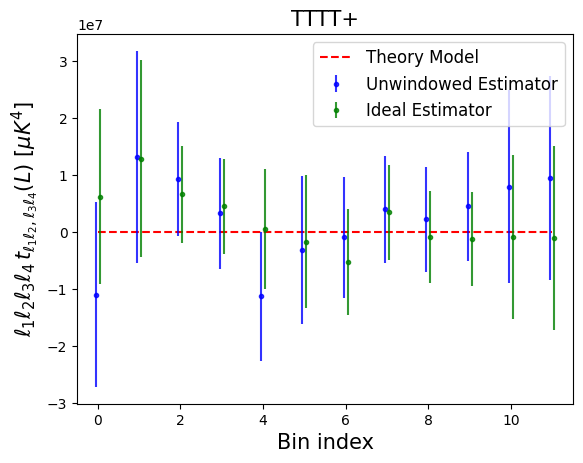

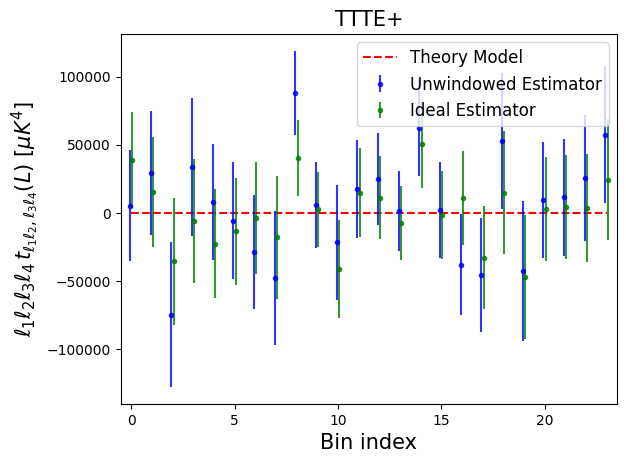

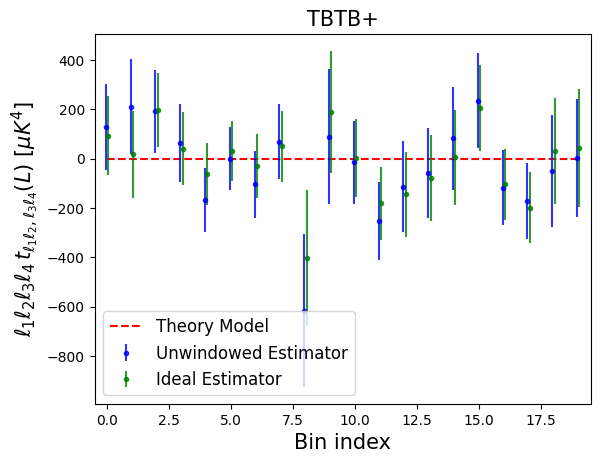

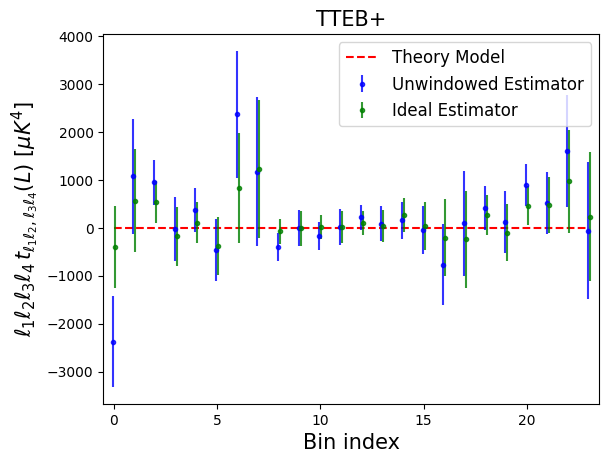

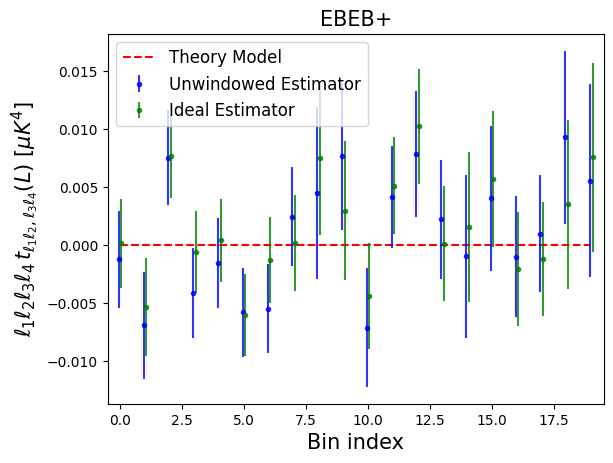

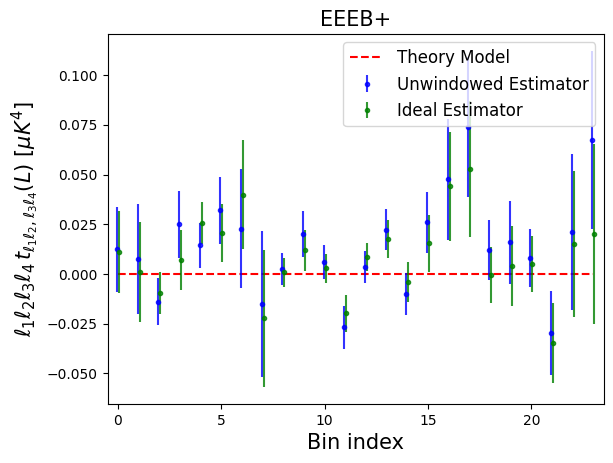

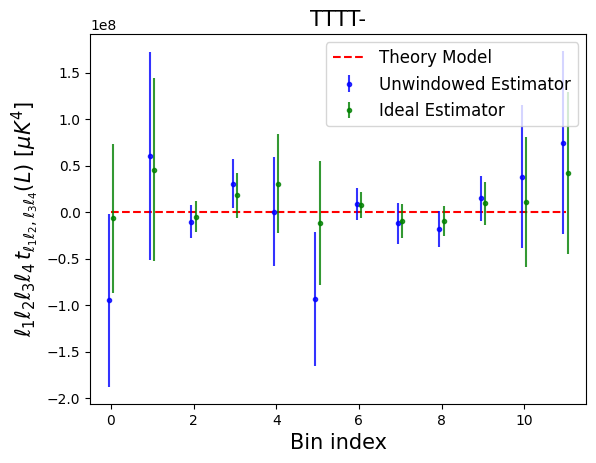

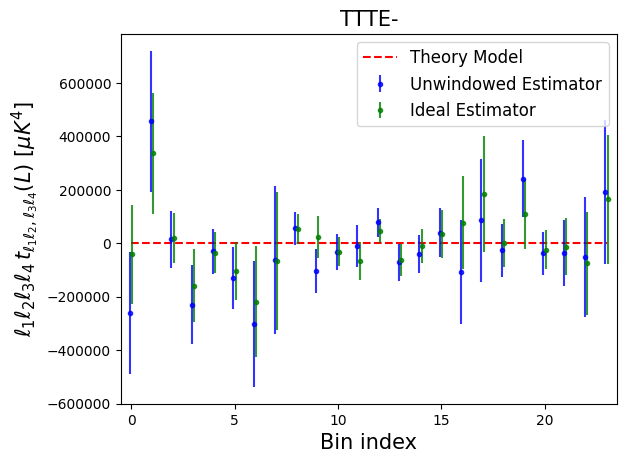

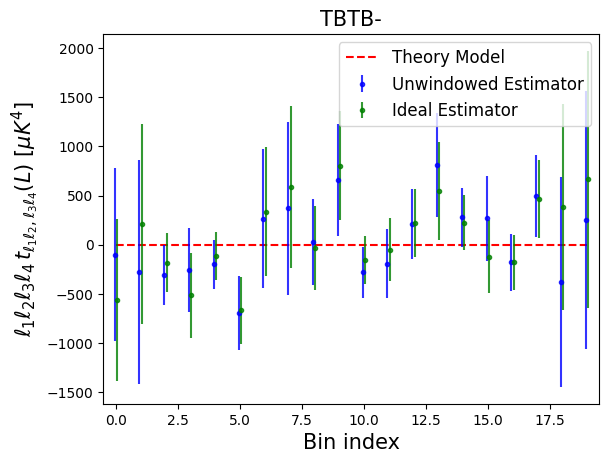

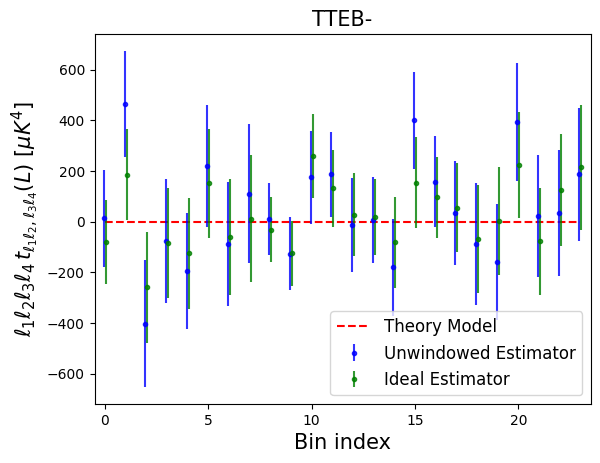

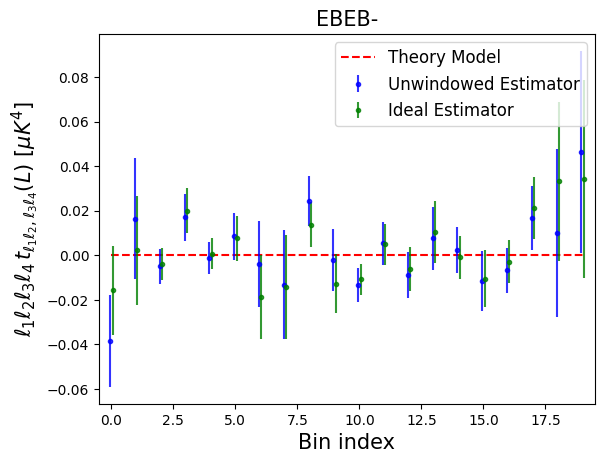

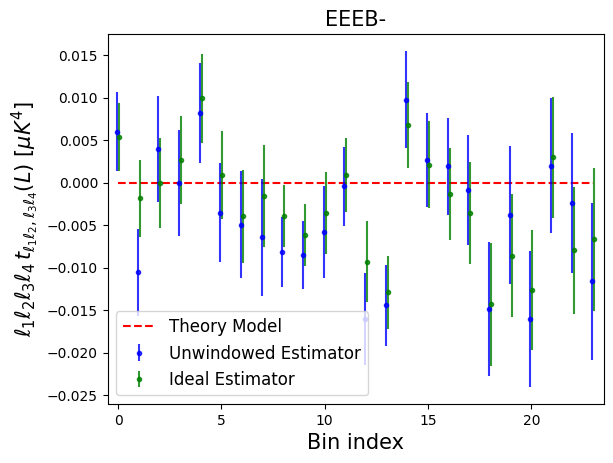

In [33]:
index = 0
for i,f in enumerate(t_ideal.keys()):
    
    # Define weights and model
    l1s,l2s,l3s,l4s,Ls = np.asarray(tspec.get_ells(field=f[:-1]))
    weights = l1s*l2s*l3s*l4s*1e24
    
    # Fisher Error
    fish_err = np.sqrt(np.diag(tspec.inv_fish)[index:index+len(tspec.sym_factor_all[i])])
    fish_err_ideal = np.sqrt(np.diag(tspec.inv_fish_ideal)[index:index+len(tspec.sym_factor_all[i])])*np.sqrt(np.mean(mask**8.)/np.mean(mask**4)**2)
    index += len(tspec.sym_factor_all[i])

    plt.figure()
    x_arr = np.arange(len(fish_err_ideal))
    plt.plot(x_arr, weights*0.,label='Theory Model',c='r',ls='--')
    plt.errorbar(x_arr-0.05,weights*t_unwindowed[f],yerr=weights*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
    plt.errorbar(x_arr+0.05,weights*t_ideal[f],yerr=weights*fish_err_ideal,ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
    plt.xlim([-0.5,len(x_arr)-0.5])
    plt.xlabel(r'Bin index',fontsize=15)
    plt.ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,t_{\ell_1\ell_2,\ell_3\ell_4}(L)\,\,[\mu K^4]$',fontsize=15)
    plt.legend(fontsize=12)
    plt.title('%s'%f, fontsize=15)

These look reasonable. Note that using too few simulations for the disconnected contributions (those loaded in ```generate_sims``` or ```load_sims```) can increase the variance of the estimator and cause differences between the ideal and unwindowed estimator, even with a uniform mask.

Let's look at the Fisher matrix:

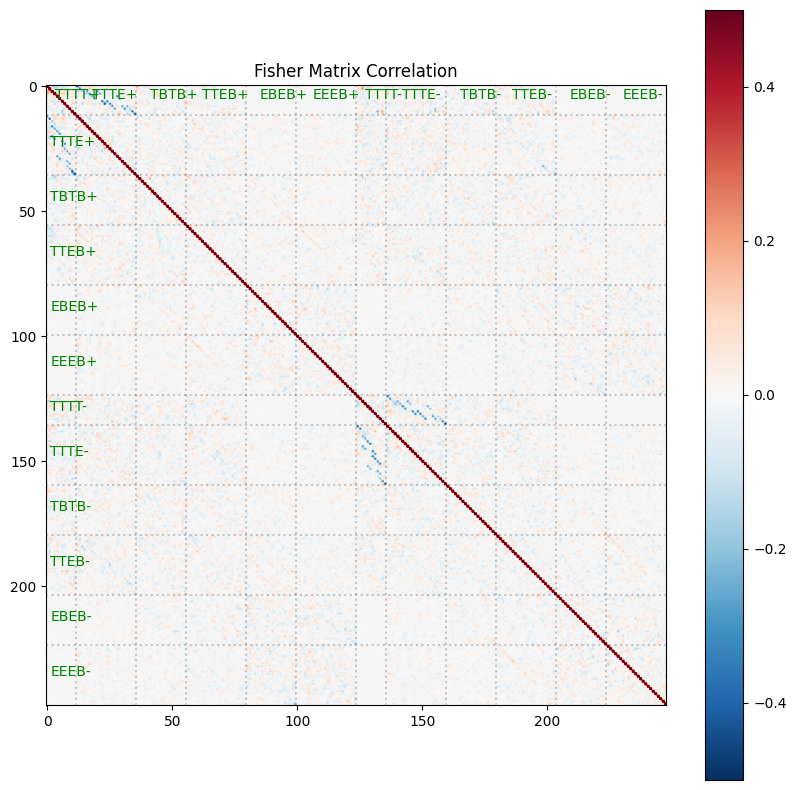

In [34]:
plot_tri_correlation(tspec.fish, v=0.5, title='Fisher Matrix Correlation', remove_diagonal=False)

This has a complex structure due to the mask and the correlation between trispectra with different diagonals.

## Validation

### Gaussian Terms

Validation is a little more tricky for trispectra, since generating data with a non-zero trispectrum is non-trivial. However, we can straightforwardly test the parity-even pieces by comparing the *full* trispectrum (without subtraction of disconnected components) to the Gaussian expectation. For simplicity, we'll look only at the trispectrum numerator (since each component is multiplied by the same Fisher matrix) and iterate over some GRF simulations:

In [35]:
# Define arrays
tC_num = []
t4_num = []
t2_num = []
t0_num = []

# Compute 0-field term
t0 = tspec.t0_num

N_grf = 10
for i in range(N_grf):
    print("\nAnalyzing GRF %d of %d"%(i+1,N_grf))
    grf_data = mask*base.generate_data(seed=i, add_B=False)
    # Connected term
    this_tC = tspec.Tl_numerator(grf_data, verb=(i==0), include_disconnected_term=True)
    # 4-field term
    this_t4 = tspec.Tl_numerator(grf_data, verb=(i==0), include_disconnected_term=False)
    # 2-field term
    this_t2 = this_tC-this_t4-t0
    # Add to arrays
    tC_num.append(this_tC)
    t4_num.append(this_t4)
    t2_num.append(this_t2)
    t0_num.append(t0)


Analyzing GRF 1 of 10
Using precomputed t0 term
Computing H maps
Computing A_lm fields
# Assembling trispectrum numerator (4-field term)
Analyzing 4-field trispectrum numerator for field TTTT
Analyzing 4-field trispectrum numerator for field TTTE
Analyzing 4-field trispectrum numerator for field TBTB
Analyzing 4-field trispectrum numerator for field TTEB
Analyzing 4-field trispectrum numerator for field EBEB
Analyzing 4-field trispectrum numerator for field EEEB
# Assembling 2-field trispectrum numerator for simulation pair 0 of 50 
# Assembling 2-field trispectrum numerator for simulation pair 1 of 50 
# Assembling 2-field trispectrum numerator for simulation pair 2 of 50 
# Assembling 2-field trispectrum numerator for simulation pair 3 of 50 
# Assembling 2-field trispectrum numerator for simulation pair 4 of 50 
# Assembling 2-field trispectrum numerator for simulation pair 5 of 50 
# Assembling 2-field trispectrum numerator for simulation pair 6 of 50 
# Assembling 2-field trispec

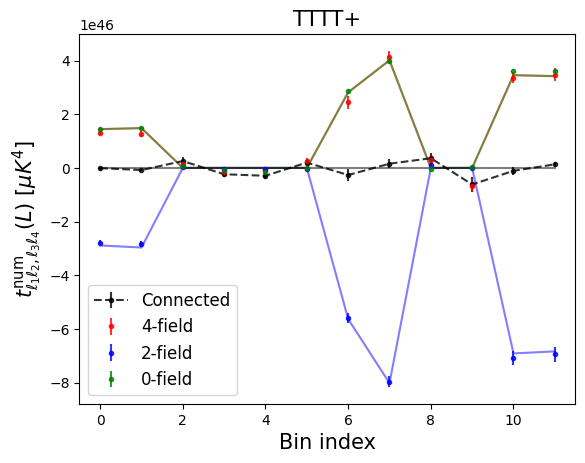

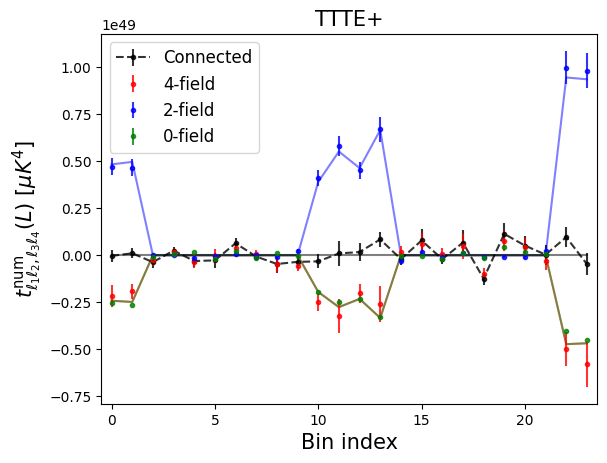

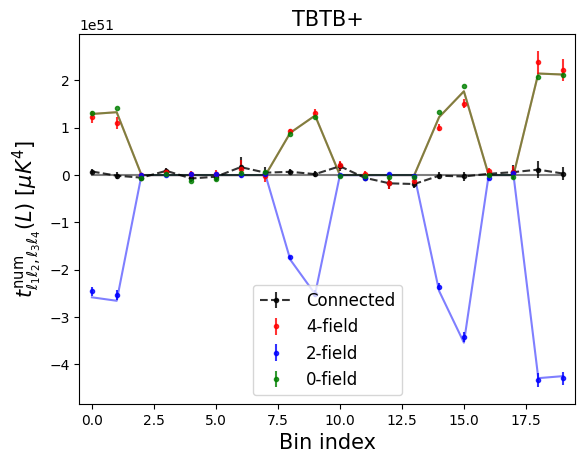

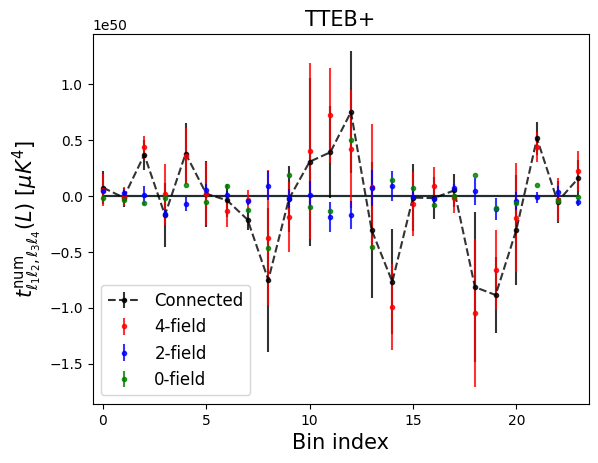

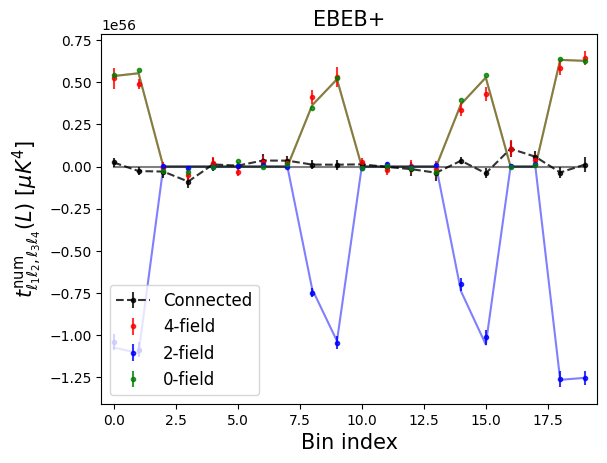

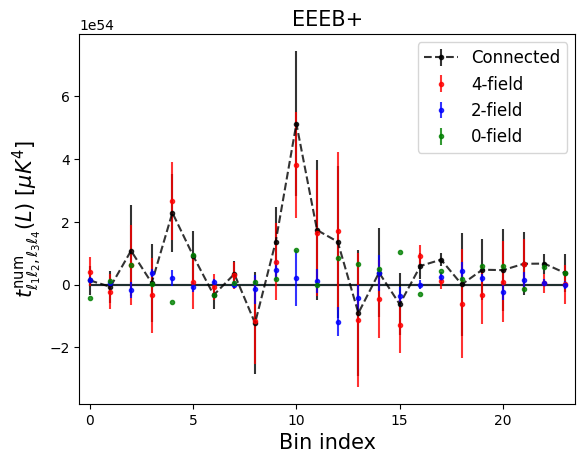

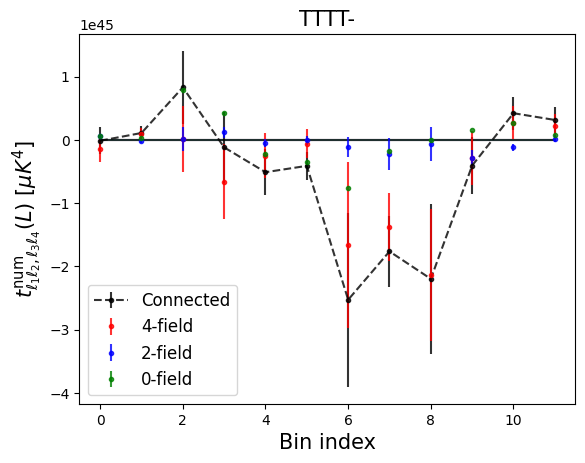

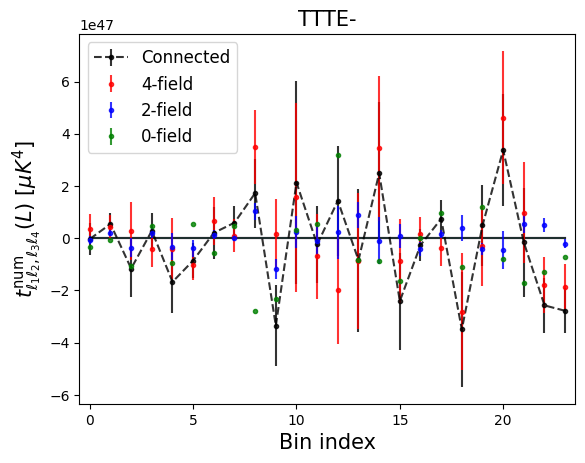

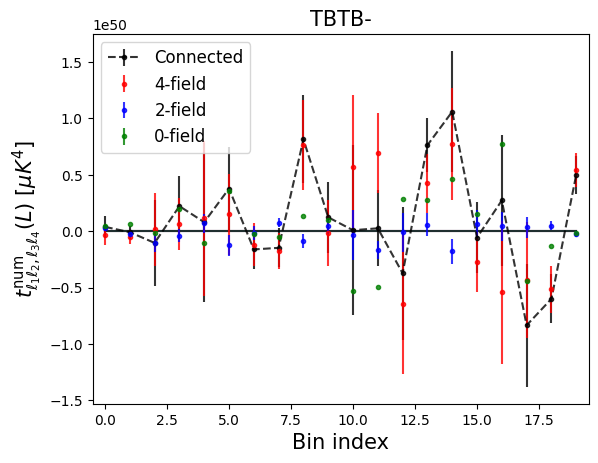

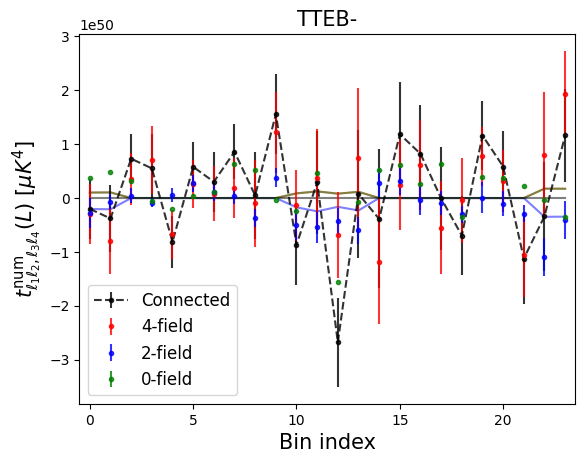

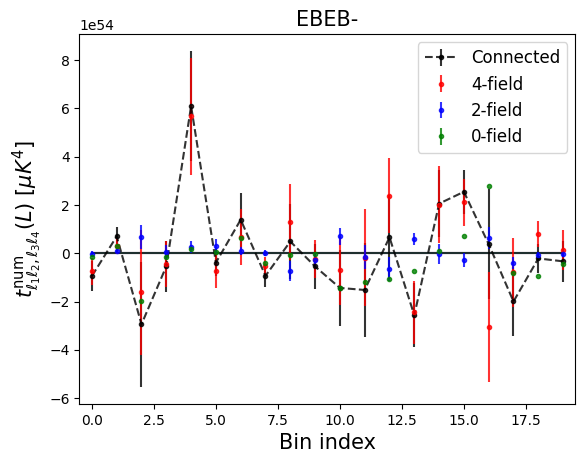

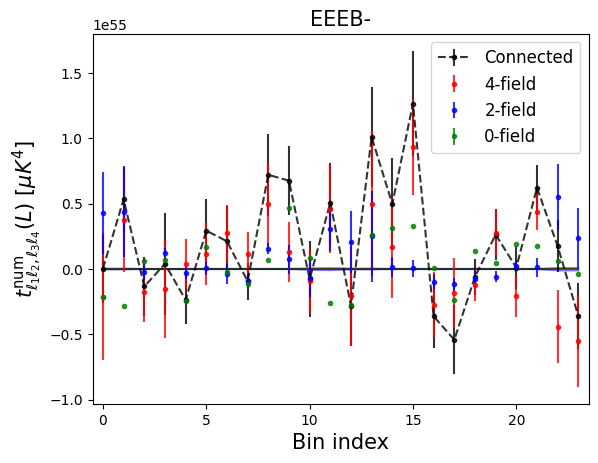

In [36]:
index = 0
for i,f in enumerate(t_ideal.keys()):
    
    # Define weights and model
    l1s,l2s,l3s,l4s,Ls = np.asarray(tspec.get_ells(field=f[:-1]))
    weights = 1e24*(1.+0.*l1s)
    
    # Define indices
    ind = np.arange(index,index+len(tspec.sym_factor_all[i]))
    
    plt.figure()
    x_arr = np.arange(len(ind))
    # Theoretical expectations (only valid without a mask)
    if np.abs(np.mean(mask)-1.)<1e-4:
        plt.plot(x_arr,weights*tspec.t0_num_ideal[ind],c='r',alpha=0.5)
        plt.plot(x_arr,weights*-2*tspec.t0_num_ideal[ind],c='b',alpha=0.5)
        plt.plot(x_arr,weights*tspec.t0_num_ideal[ind],c='g',alpha=0.5)
        plt.plot(x_arr,weights*0.,c='k',alpha=0.5)
    # Data
    plt.errorbar(x_arr,weights*np.mean(tC_num,axis=0)[ind],yerr=weights*np.std(tC_num,axis=0)[ind]/np.sqrt(N_grf),marker='.',ls='--',label='Connected',c='k',alpha=0.8)
    plt.errorbar(x_arr,weights*np.mean(t4_num,axis=0)[ind],yerr=weights*np.std(t4_num,axis=0)[ind]/np.sqrt(N_grf),marker='.',ls='',label='4-field',c='r',alpha=0.8)
    plt.errorbar(x_arr,weights*np.mean(t2_num,axis=0)[ind],yerr=weights*np.std(t2_num,axis=0)[ind]/np.sqrt(N_grf),marker='.',ls='',label='2-field',c='b',alpha=0.8)
    plt.errorbar(x_arr,weights*np.mean(t0_num,axis=0)[ind],yerr=weights*np.std(t0_num,axis=0)[ind]/np.sqrt(N_grf),marker='.',ls='',label='0-field',c='g',alpha=0.8)
    plt.xlim([-0.5,len(x_arr)-0.5])
    plt.xlabel(r'Bin index',fontsize=15)
    plt.ylabel(r'$t^{\mathrm{num}}_{\ell_1\ell_2,\ell_3\ell_4}(L)\,\,[\mu K^4]$',fontsize=15)
    plt.legend(fontsize=12)
    plt.title('%s'%f, fontsize=15)
   
    
    index += len(tspec.sym_factor_all[i])

For parity-conserving spectra, we note that the $4$-field term is approximately equal to the $0$-field term, and $-(1/2)\times$ the $2$-field term, each of which is close to the theoretical expectation (solid lines). This is as expected, and the sum cancels (up to noise). For parity-breaking spectra, there is no net contribution from any term.

Finally, we note that this is a sufficient test also for parity-odd spectra, since they are formulated in exactly the same manner, except with a restriction to $p_u(-1)^{\ell_1+\ell_2+\ell_3+\ell_4}=-1$ instead of $+1$.

### Iterate over multiple data-sets

Just as before, we can test the estimator covariances with some mock data. This remains (comparatively) cheap, since we don't need to reload Monte Carlo simulations or recompute the Fisher matrix.

In [37]:
# Set counters to zero
base.n_SHTs_forward, base.n_SHTs_reverse = 0, 0

# Define arrays
t_unwindowed_all = {f:[] for f in t_ideal.keys()}
t_ideal_all = {f:[] for f in t_ideal.keys()}

for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    data = mask*base.generate_data(jj,add_B=False)
    
    # Analyze sim
    this_Tl_ideal = tspec.Tl_ideal(data, verb=False)
    this_Tl_unwindowed = tspec.Tl_unwindowed(data, verb=False)
    
    # Add to arrays
    for f in t_ideal.keys():
        t_ideal_all[f].append(this_Tl_ideal[f])
        t_unwindowed_all[f].append(this_Tl_unwindowed[f])
    
# Print some diagnostics
print("Computation complete using %d forward and %d reverse SHTs per simulation"%(base.n_SHTs_forward//N_sim, base.n_SHTs_reverse//N_sim))

Analyzing simulation 1 of 50


100%|██████████| 124/124 [00:00<00:00, 346.56it/s]


Analyzing simulation 11 of 50


100%|██████████| 124/124 [00:00<00:00, 341.19it/s]


Analyzing simulation 21 of 50


100%|██████████| 124/124 [00:00<00:00, 343.36it/s]


Analyzing simulation 31 of 50


100%|██████████| 124/124 [00:00<00:00, 345.51it/s]


Analyzing simulation 41 of 50


100%|██████████| 124/124 [00:00<00:00, 348.96it/s]


Computation complete using 2146 forward and 14 reverse SHTs per simulation


Below, we plot the various components, averaged over the realizations, and then their errors. As expected, the results are consistent with zero in all cases (though we caution that deviations will appear if one uses too few simulations in the estimator, which does not show up in the variances). Moreover, the variance of the unwindowed estimators is close to the Fisher matrix, showing that things are close to optimal. As before, the ideal estimators seem to have lower variance; this is due to the correlations between adjacent bins, and does not lead to increased signal-to-noise.

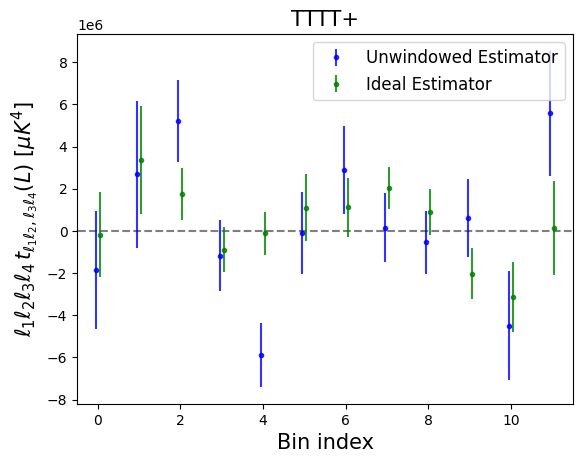

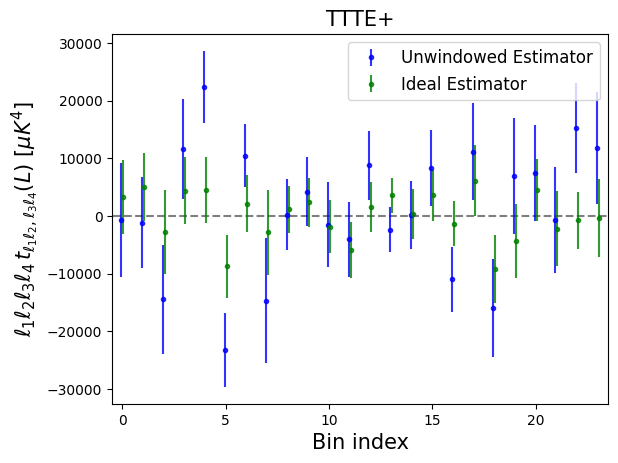

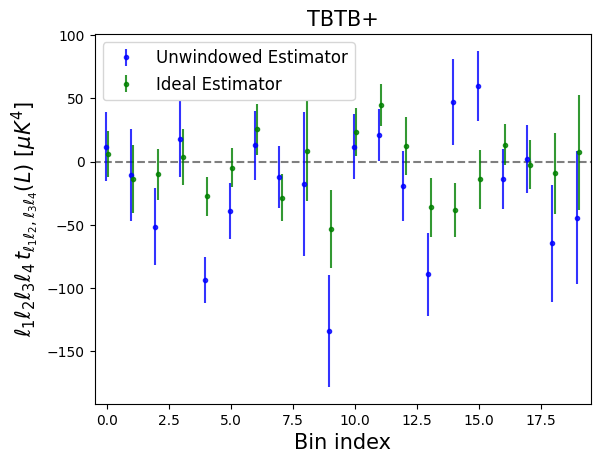

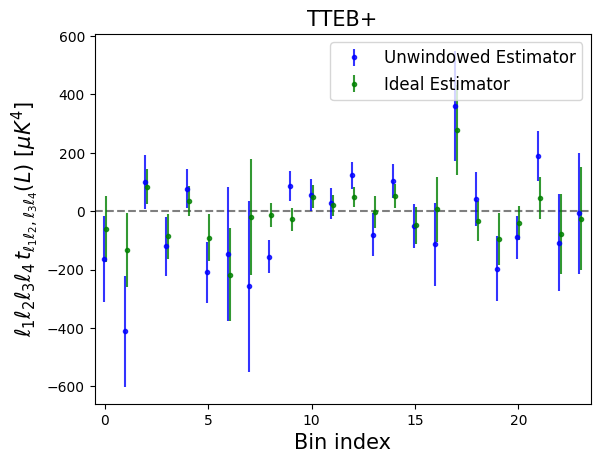

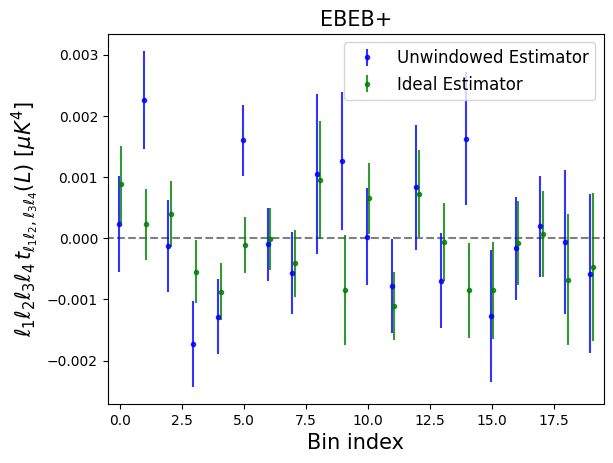

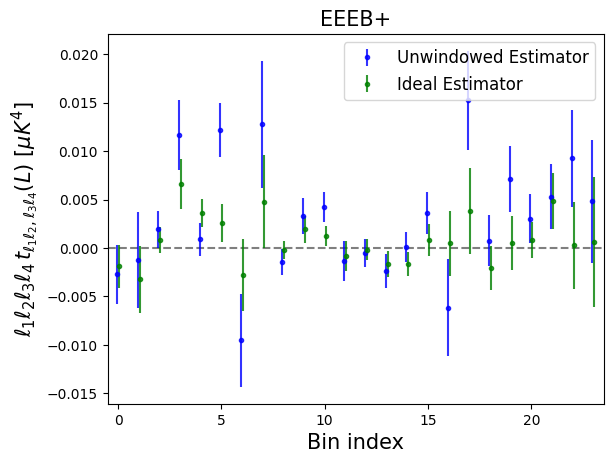

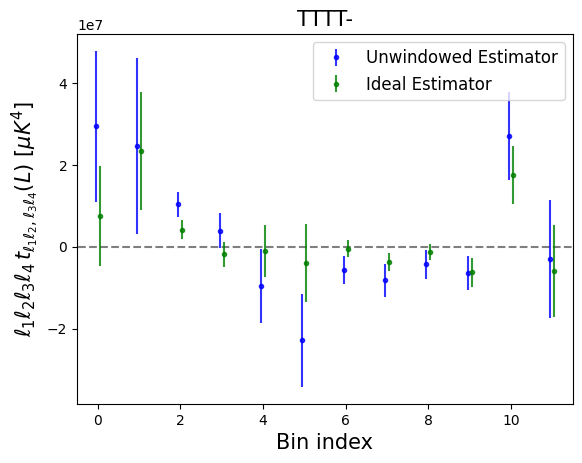

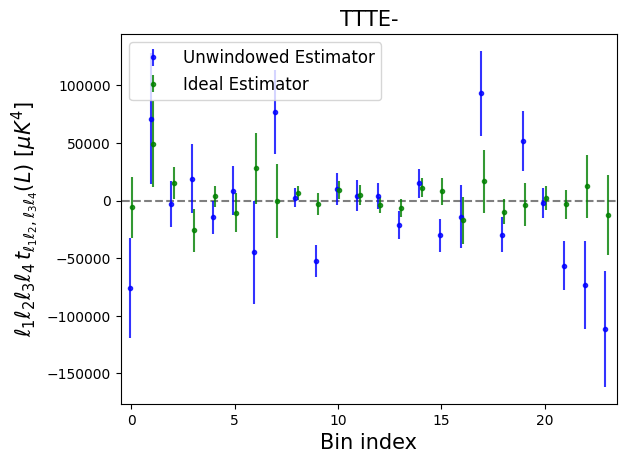

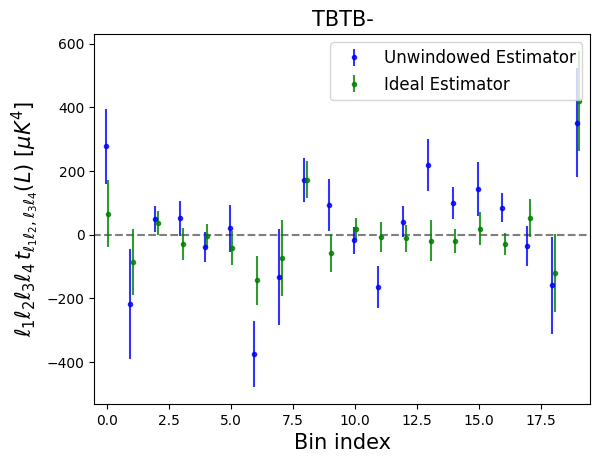

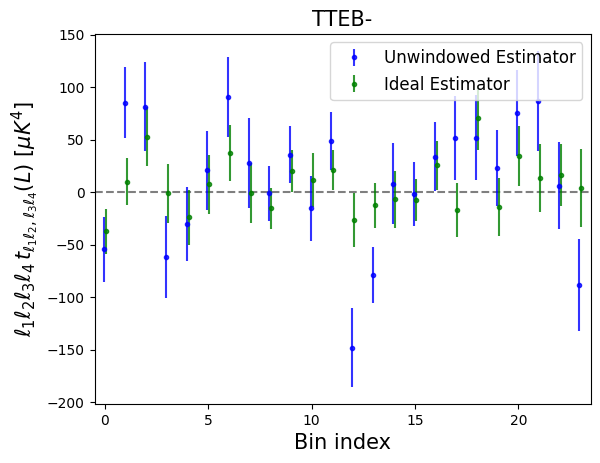

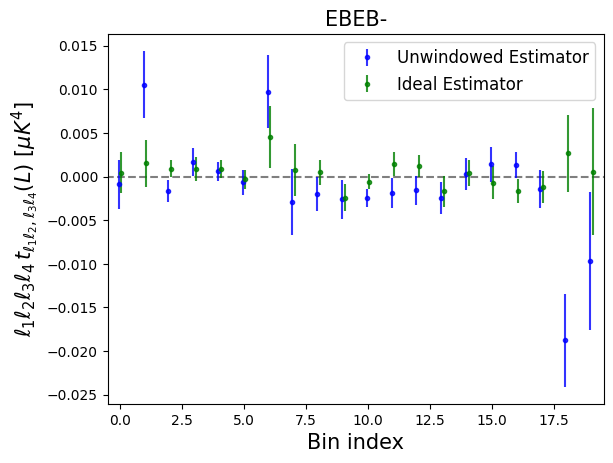

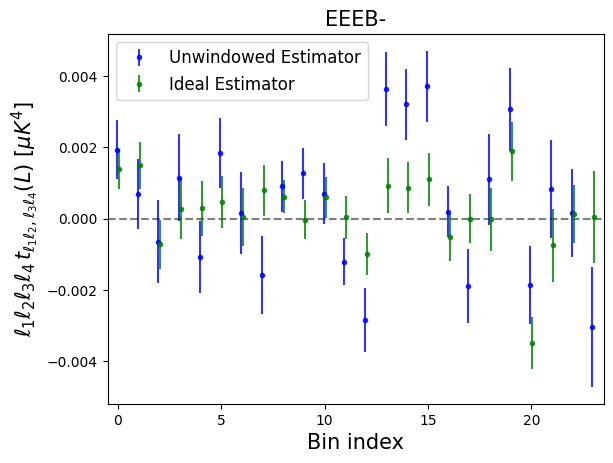

In [41]:
index = 0
for i,f in enumerate(t_ideal.keys()):
    
    # Define weights
    l1s,l2s,l3s,l4s,Ls = np.asarray(tspec.get_ells(field=f[:-1]))
    weights = l1s*l2s*l3s*l4s*1e24
    
    # Plot means
    plt.figure()
    x_arr = np.arange(len(tspec.sym_factor_all[i]))
    plt.hlines(0,-1,len(x_arr)+1,linestyles='--',color='k',alpha=0.5)
    plt.errorbar(x_arr-0.05,weights*np.mean(t_unwindowed_all[f],axis=0),yerr=weights*np.std(t_unwindowed_all[f],axis=0)/np.sqrt(N_sim),marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
    plt.errorbar(x_arr+0.05,weights*np.mean(t_ideal_all[f],axis=0),yerr=weights*np.std(t_ideal_all[f],axis=0)/np.sqrt(N_sim),ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
    plt.xlim([-0.5,len(x_arr)-0.5])
    plt.xlabel(r'Bin index',fontsize=15)
    plt.ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,t_{\ell_1\ell_2,\ell_3\ell_4}(L)\,\,[\mu K^4]$',fontsize=15)
    plt.legend(fontsize=12)
    plt.title('%s'%f, fontsize=15)

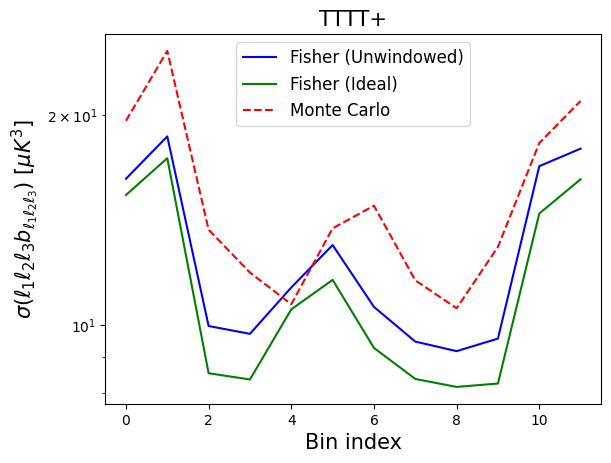

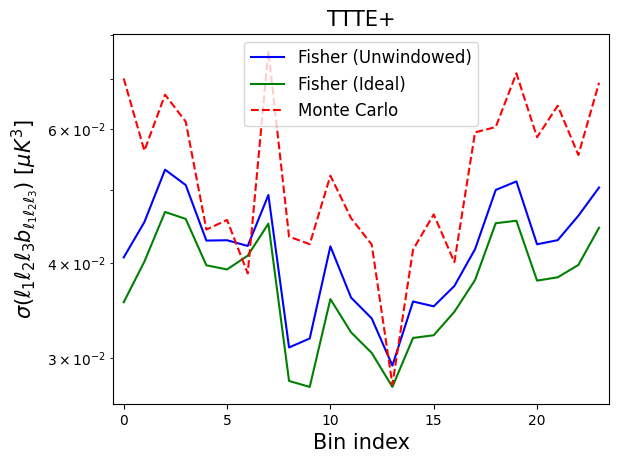

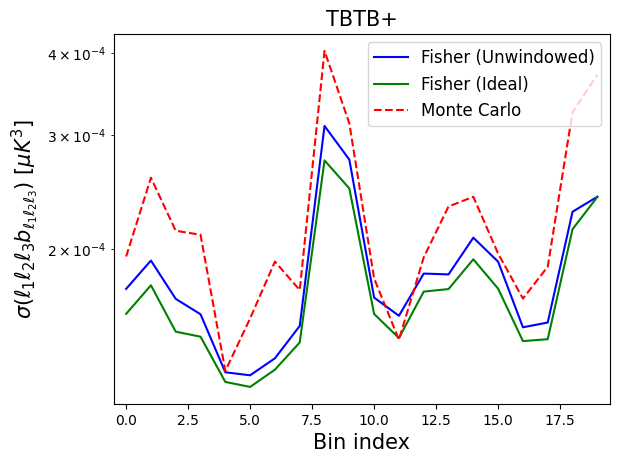

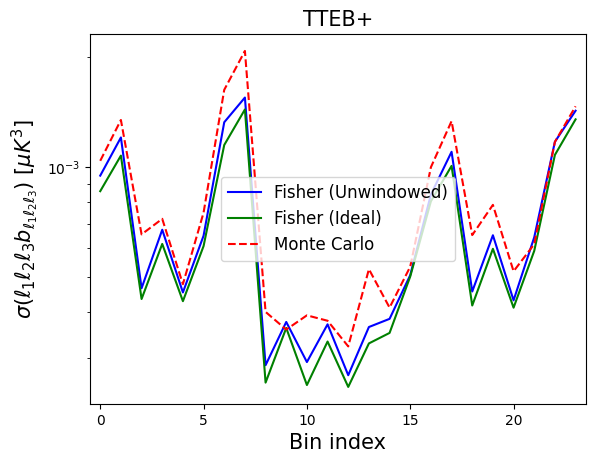

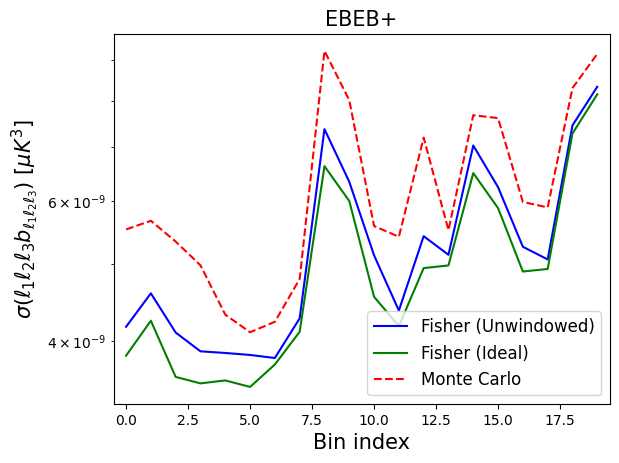

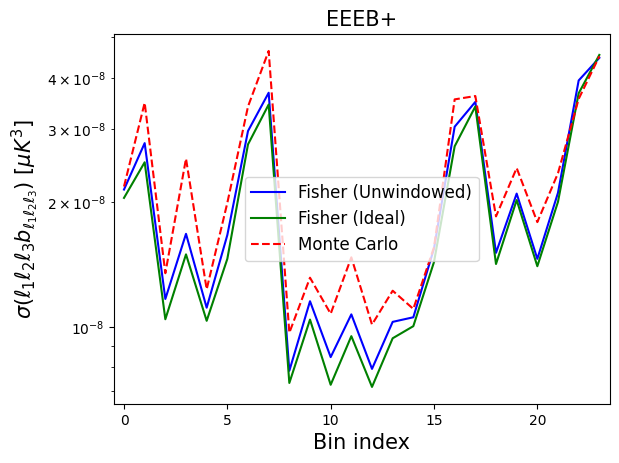

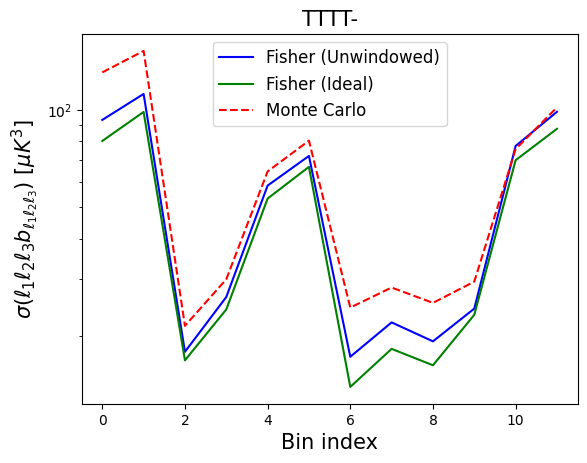

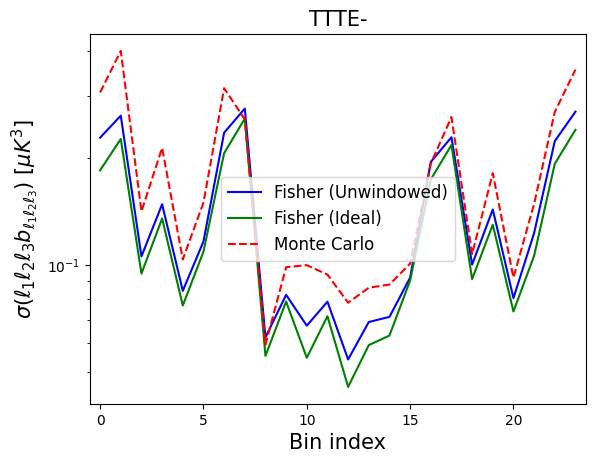

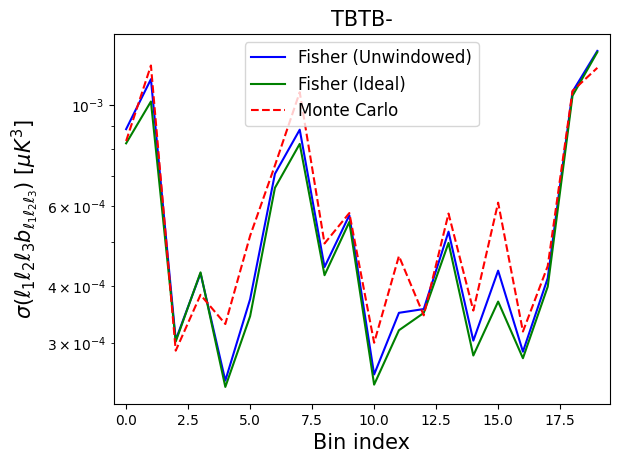

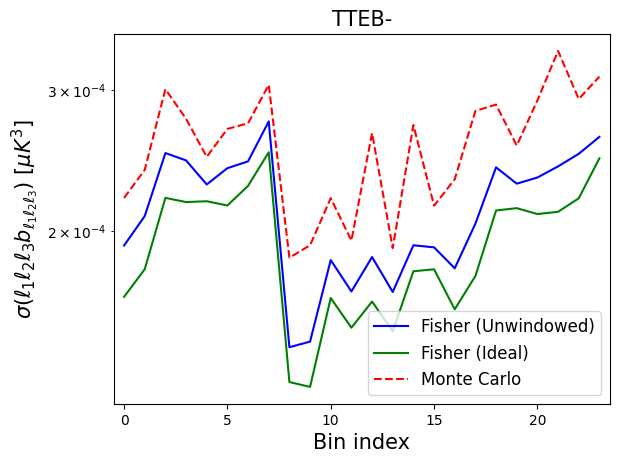

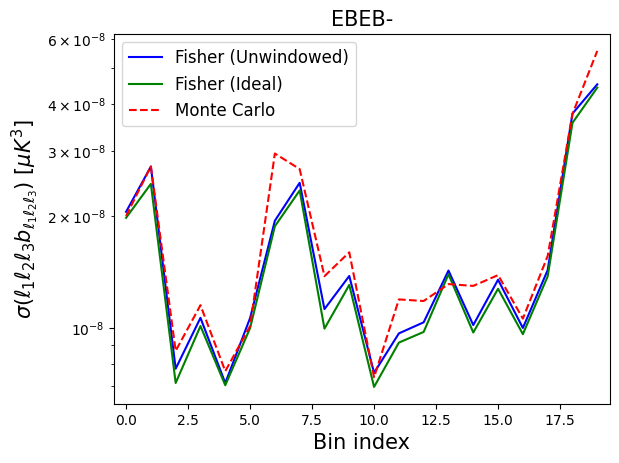

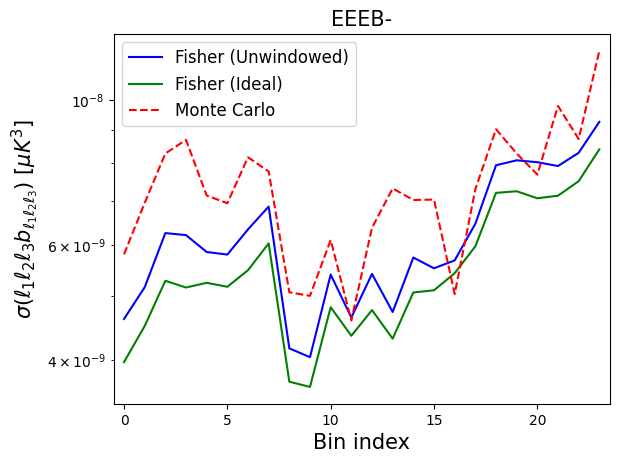

In [42]:
index = 0
for i,f in enumerate(t_ideal.keys()):
    
    # Define weights
    l1s,l2s,l3s,l4s,Ls = np.asarray(tspec.get_ells(field=f[:-1]))
    weights = l1s*l2s*l3s*l4s*1e18
    
    # Fisher Error
    fish_err = np.sqrt(np.diag(tspec.inv_fish)[index:index+len(tspec.sym_factor_all[i])])
    fish_err_ideal = np.sqrt(np.diag(tspec.inv_fish_ideal)[index:index+len(tspec.sym_factor_all[i])])*np.sqrt(np.mean(mask**6.)/np.mean(mask**3)**2)
    index += len(tspec.sym_factor_all[i])
    
    # Plot errors
    plt.figure()
    x_arr = np.arange(len(fish_err))
    plt.plot(x_arr,weights*fish_err,label='Fisher (Unwindowed)',c='b')
    plt.plot(x_arr,weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
    plt.plot(x_arr,weights*np.asarray(t_unwindowed_all[f]).std(axis=0),label='Monte Carlo',c='r',ls='--')
    plt.xlabel(r'Bin index',fontsize=15)
    plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);
    plt.xlim([-0.5,len(x_arr)-0.5])
    plt.legend(fontsize=12)
    plt.title('%s'%f, fontsize=15)
    plt.yscale('log')

Finally we compare the correlation structure of the estimator to the inverted Fisher matrix; this is noisy, but shows good overall agreement.

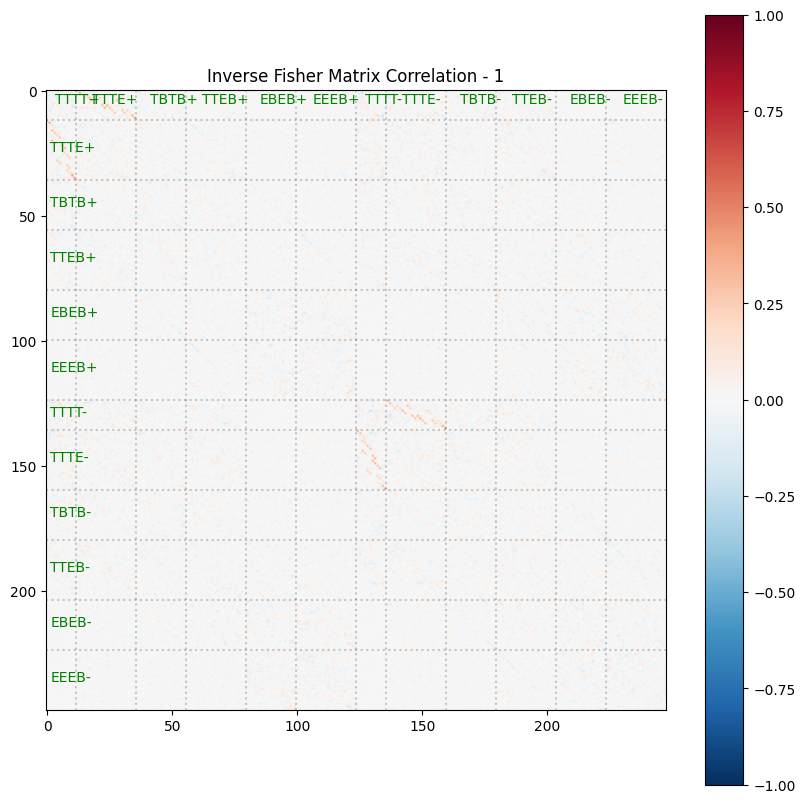

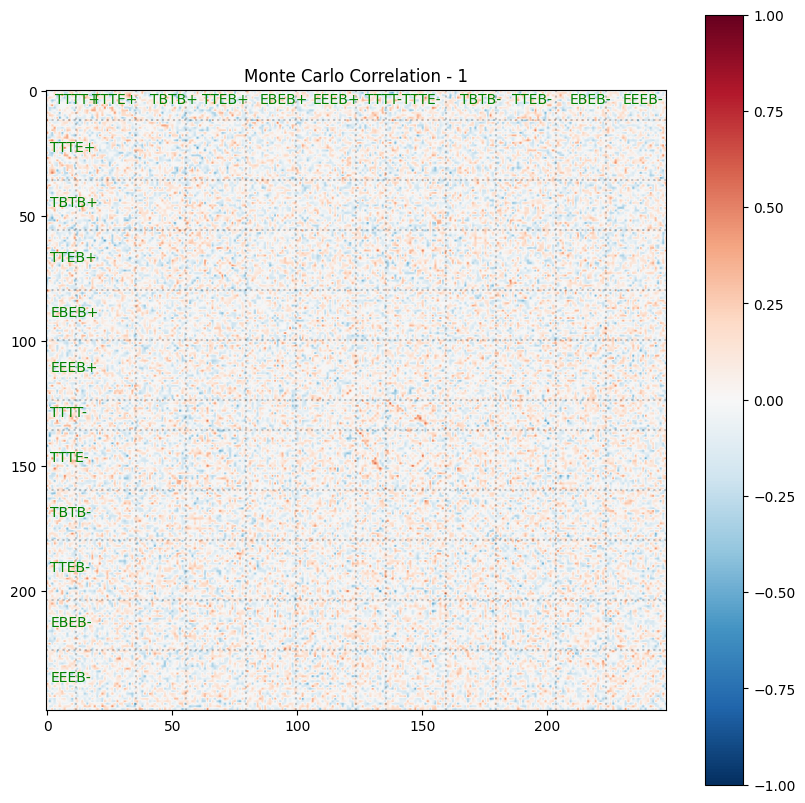

In [40]:
cov_ideal = np.cov(np.hstack([t_unwindowed_all[f] for f in t_ideal.keys()]).T)
plot_tri_correlation(np.linalg.inv(tspec.fish), title='Inverse Fisher Matrix Correlation - 1', v=1.)
plot_tri_correlation(cov_ideal, title='Monte Carlo Correlation - 1', v=1.)

## This computes the tutorial! For any questions, please open a GitHub issue or contact [Oliver Philcox](ohep2@cantab.ac.uk).

# NOTES

# cleanup notebook 
### remove testing section!
### also add actual validation plots

## also cleanup repository!